In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore", message=".*Estimation was terminated because no further improvement.*")

print(np.__version__)

/Users/gabrielvincenzi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.26.4


\section{The political and democratic channel}
How different individuals vote and how this creates lobbies influencing fiscal policy. The conclusions of \textcite{Dotti}, stemming from the political economy world that the progressivity of the tax system is increasing in the mean-to-median income ratio and so higher income inequality implies a more progressive tax system, are related to the previous concept of marginal labor elasticities.

\section{The public spending channel}
How different individuals’ behavior and role in the society shapes the public spending, given unemployment, suburban zones or aging population.

\section{The behavioral channel}
How individuals’ different propensity to consume, elasticity to taxation, tendency to evade shape the effect and the available budget of a policy.

\section{The opportunity channel}
How better infrastructures in education, transportation and health influence the administrative budget constraint in an inter temporal setup.

## Importing SHIW files

In [2]:
comp = pd.read_csv("CSV/comp.csv")
cons = pd.read_csv("CSV/cons.csv")
fami = pd.read_csv("CSV/fami.csv")
immp = pd.read_csv("CSV/immp.csv")
imma = pd.read_csv("CSV/imma.csv")
ldip = pd.read_csv("CSV/ldip.csv")
rfam = pd.read_csv("CSV/rfam.csv")
ricf = pd.read_csv("CSV/ricf.csv")
rper = pd.read_csv("CSV/rper.csv")
linb = pd.read_csv("CSV/linb.csv")
linc = pd.read_csv("CSV/linc.csv")
lind = pd.read_csv("CSV/lind.csv")
pens = pd.read_csv("CSV/pens.csv", low_memory=False)
tras = pd.read_csv("CSV/tras.csv")
defl = pd.read_csv("CSV/defl.csv")
weight = pd.read_csv("CSV/peso.csv")

## Definining Tax Schedules

In [3]:
def to_euro(data, divisor = 1936.27):
    """
    Given an initial dictionary like object containing as keys the year and a divisor = 1936.27,
    return the same dictionary like object where all currencies are expressed in euros.
    """
    for year, values in data.items():
        if year < 2002:  # Only apply the transformation to years before 2001
            new_values = {}
            for key, value in values.items():
                if isinstance(key, (int, float)):  # Check if the key is numeric
                    new_key = key * 1000000 / divisor
                    new_key = round(new_key, 2)
                    new_values[new_key] = value
                else:
                    new_values[key] = value  # Keep the non-numeric keys as they are
            data[year] = new_values
    return data


TaxSchedules_lire = {
    1982: {
        3: 10,
        4: 13,
        5: 16,
        6: 19,
        7.5: 22,
        9: 25,
        11: 27,
        13: 29,
        15: 31,
        17: 32,
        19: 33,
        22: 34,
        25: 35,
        30: 36,
        35: 38,
        40: 40,
        50: 42,
        60: 44,
        80: 46,
        100: 48,
        125: 50,
        150: 52,
        175: 54,
        200: 56,
        250: 58,
        300: 60,
        350: 62,
        400: 64,
        450: 66,
        500: 68,
        550: 70,
        "over": 72,
    },

    1985 : {
        11: 18,
        24: 27,
        30: 35,
        38: 37,
        60: 41,
        120: 47,
        250: 56,
        500: 62,
        "over": 65,
    },

    1988: {
        6: 12,
        11: 22,
        28: 27,
        50: 34,
        100: 41,
        150: 48,
        300: 53,
        600: 58,
        "over": 62,
    },

    1989: {
        6: 10,
        12: 22,
        30: 26,
        60: 33,
        150: 40,
        300: 45,
        "over": 50,
    },

    1990: {
        6.4: 10,
        12.7: 22,
        31.8: 26,
        63.7: 33,
        159.1: 40,
        318.3: 45,
        "over": 50,
    },

    1991 : {
        6.8: 10,
        13.5: 22,
        33.7: 26,
        67.6: 33,
        168.8: 40,
        337.7: 45,
        "over": 50,
    },

    1997: {
        7.2: 10,
        14.4: 22,
        30: 27,
        60: 34,
        150: 41,
        300: 46,
        "over": 51,
    },

    1999 : {
        15: 18.5,
        30: 26.5,
        60: 33.5,
        135: 39.5,
        "over": 45.5,
    },

    2000 : {
        20: 18.5,
        30: 25.5,
        60: 33.45,
        135: 39.5,
        "over": 45.5,
    },

    2001 : {
        20: 18,
        30: 24,
        60: 32,
        135: 39,
        "over": 45,
    },

    2002 : {
        10329.14: 18,
        15493.71: 24,
        30987.68: 32,
        69721.68: 39,
        "over": 45,
    },

    2004 : {
        15000: 23,
        29000: 29,
        32600: 31,
        70000: 39,
        "over": 45,
    },

    2005 : {
        26000: 23,
        33000: 33,
        100000: 39,
        "over": 43,
    },

    2007 : {
        15000: 23,
        28000: 27,
        55000: 38,
        75000: 41,
        "over": 43,
    },

    2022 : {
        15000: 23,
        28000: 25,
        50000: 35,
        "over": 43,
    },

    2024 : {
        28000: 23,
        50000: 35,
        "over": 43,
    },
}
    
TaxScheduleForf_2015 = 5
TaxScheduleForf_2024 = 15

TaxSchedules = to_euro(TaxSchedules_lire)

TaxSchedules_cap ={
    1998: 0,
    2011: 12.5,
    2013:20,
    2024:26
    }

## Utility old

In [4]:
def real_attach(df, columns, deflator):
    for col in columns:
        df[f"Real_{col}"] = (df[col] / df[deflator]) * 100
        df[f"Ln_{col}"] = np.log(df[f"Real_{col}"])
    return df

## Utility Functions

In [5]:
#### Formatting Functions ########################################################################################################################

def formatted_df(df):
    for col in df.columns:
        if df[col].dtype != "float64" and df[col].dtype != "float32" and df[col].dtype != "int" and col != "Time":
            df[col] = df[col].str.replace(',', '.').astype(float)

    df.dropna(inplace=True)
    return df


def growth_attach(df, columns, lags):
    for l in range(1, lags+1):
        for col in columns:
            df[f"Growth_{col}_l{-l}"] = (df[col] - df[col].shift(l)) / df[col].shift(l)
    return df


def log_attach(df, columns, lags):
    for l in range(1, lags+1):
        for col in columns:
            df[f"Ln_{col}_l{-l}"] = np.log(df[col].shift(l))
    return df


def tramo_seats(df, to_adjust_cols, path, real=False, deflator=None):
    for col in to_adjust_cols:
        s = pd.Series(df[col], index=df.index)
        res = sm.tsa.x13_arima_analysis(s, x12path=path)
        df[col] = res.seasadj

        if real:
            df[f"Real_{col}"] = (df[col] / df[deflator]) * 100
            df[f"Ln_{col}"] = np.log(df[f"Real_{col}"])

    return df


#### Econometrics Functions ########################################################################################################################

def vif(X):
    X_vif = X.drop('const', axis=1)  # Remove the constant column before calculating VIF
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X_vif.columns
    vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

    print(vif_data)


def acf_residuals_plot(df, model_lags, criterion='aic', figsize=(20,30), plot_lags=20):
    model = VAR(df)
    results = model.fit(maxlags=model_lags, ic=criterion)
    residuals = results.resid

    print("Durbin-Watson statistics for residuals:")
    print(durbin_watson(residuals))  # Check for residual autocorrelation

    plt.figure(figsize=figsize)
    for i, column in enumerate(residuals.columns):
        plt.subplot(len(residuals.columns), 1, i + 1)
        plot_acf(residuals[column], ax=plt.gca(), lags=plot_lags)
        plt.title(f"ACF for residuals of {column}")
    plt.tight_layout()
    plt.show()


##### Percentiles Functions ########################################################################################################################

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)

    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) #- 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)
    thresholds = np.interp(quantiles, weighted_quantiles, values)

    # Compute bracket averages
    #bracket_averages = []
    #lower_bound = -np.inf
    #for threshold in thresholds:
    #    # Mask for the current bracket
    #    mask = (values > lower_bound) & (values <= threshold)
    #    # Weighted average
    #    if mask.any():
    #        avg = np.average(values[mask], weights=sample_weight[mask])
    #    else:
    #        avg = np.nan  # In case no values fall in this bracket
    #    bracket_averages.append(avg)
    #    lower_bound = threshold

    bracket_averages = []
    for i, threshold in enumerate(thresholds):
        if i < len(thresholds) - 1:
            next_threshold = thresholds[i + 1]
        else:
            next_threshold = np.inf

        # Mask for data within the current bracket
        mask = (values > threshold) & (values <= next_threshold)
        if mask.any():
            avg = np.average(values[mask], weights=sample_weight[mask])
        else:
            avg = np.nan
        bracket_averages.append(avg)

    return thresholds, bracket_averages


def assign_percentile(row, variable, percentiles_df):
    """
    Given a row, the variable of interest and the dataframe containing its percentiles,
    return the percentile in which the variable resides.
    For example it returns the label 'percentile_10' when value is less than or equal to the threshold of 10° percentile.
    """
    year = row['ANNO']
    value = row[variable]
    thresholds = percentiles_df.loc[year]

    # Loop through each percentile threshold to find the appropriate label
    for label, threshold in thresholds.items():
        if value <= threshold:
            return int(label.split('_')[1])  # 

    # If the value exceeds the last threshold, assign a final label
    return '100'

def get_income_quantiles(df, quantiles, column):
    thresholds_data = []
    bracketavg_data = []
    yearly_dataframes = {}

    # Calculate for each year
    for year, group in df.groupby('ANNO'):
        ylabour = group[column].values
        weights = group['PESOPOP'].values
        
        # Compute thresholds and averages
        thresholds, bracket_averages = weighted_quantile(ylabour, quantiles, weights)

        # Store Yearly dataset
        data = {
            'Percentile': [f'{int(q * 100)}%' for q in quantiles],
            'Threshold': thresholds,
            'Average': bracket_averages
        }
        df = pd.DataFrame(data)
        yearly_dataframes[year] = df
        
        # Store results
        thresholds_data.append([year] + list(thresholds))
        bracketavg_data.append([year] + list(bracket_averages))

    # Convert to DataFrames
    thresholds_df = pd.DataFrame(thresholds_data, columns=['ANNO'] + [f'percentile_{int(quantiles[i-1]*100)}' for i in range(1, len(quantiles) + 1)])
    bracketavg_df = pd.DataFrame(bracketavg_data, columns=['ANNO'] + [f'percentile_{int(quantiles[i-1]*100)}' for i in range(1, len(quantiles) + 1)])

    return thresholds_df, bracketavg_df


##### Horizons Functions ########################################################################################################################

def horizon_dfs(starting_df, horizons, column, name, columns_to_drop, lags):
    """
    Computes the cumulative growth rate between the current period and the period h steps ahead, 
    then creates a set of dataframes for each horizon in the vector of horizons.

    starting_df: pandas.DataFrame   starting dataframe from which the other are created.
    horizons: array                 horizons for which the cumulative growth rate is calculated.
    column: pandas.column           focus column of the dataframe.
    name: string                    name of the new cumulated growth column
    columns_to_drop: array          names of the eventual columns to drop after the evaluation. 
    """
    horizonVars = {}

    for h in horizons:
        df = starting_df.copy()
        df[f"{name}_h{h}"] = (df[column].shift(-h) - df[column].shift(1)) / df[column].shift(1)

        if h == 0:
            for col in columns_to_drop:
                df[f"Growth_{col}_l{-lags-1}"] = (df[col] - df[col].shift(lags+1)) / df[col].shift(lags+1)
            
        df.drop(columns=columns_to_drop, inplace=True)
        df.dropna(inplace=True)
        horizonVars[f"Model_h{h}"] = df

    return horizonVars


##### Taxation Functions ########################################################################################################################

def get_tax_schedule(year, tax_schedules):
    """
    Given a particular year and a dictionary like object for the tax schedules,
    return the applicable tax schedule.
    """
    applicable_years = tax_schedules.keys()
    for schedule_year in applicable_years:
        if year <= schedule_year:
            return tax_schedules[schedule_year]
        
    return tax_schedules[applicable_years[-1]]


def calculate_tax_amount(income, tax_schedule):
    """
    Given a particular income and a dictionary like tax schedule,
    return the total tax amount for each income.
    """
    tax_amount = 0.0
    previous_limit = 0.0

    # Use the "over" rate for income above the last threshold
    over_rate = tax_schedule.get("over", 0)

    # Calculate the tax for each bracket
    for limit, rate in tax_schedule.items():
        if limit == "over":
            continue

        if income > limit:
            # Calculate tax for the full bracket amount (up to `limit`)
            tax_amount += (limit - previous_limit) * (rate / 100)
            previous_limit = limit
        else:
            # Apply the tax rate for the remaining income and finish
            tax_amount += (income - previous_limit) * (rate / 100)
            return tax_amount

    # Apply the "over" rate for any income beyond the last bracket
    tax_amount += (income - previous_limit) * (over_rate / 100)
    return tax_amount


def calculate_individual_tax(row):
    year = row['ANNO']
    income = row['YLabour']
    tax_schedule = get_tax_schedule(year, TaxSchedules)
    return calculate_tax_amount(income, tax_schedule)


def get_marginal_tax_rate(income, year, tax_schedules):
    """
    Given an income value and a tax schedule dictionary,
    return the marginal tax rate applicable to that income.
    """
    available_years = [year for year in tax_schedules.keys() if year != "over"]
    next_year = min([y for y in available_years if y >= year], default=None)
    if next_year is None:
        raise ValueError(f"No tax schedule available for year {year}")
    
    tax_schedule = tax_schedules[next_year]

    # Iterate over the tax schedule thresholds handling the "over" case
    for threshold in tax_schedule.keys():
        if threshold == "over":
            return tax_schedule[threshold]
        
        elif income <= threshold:
            return tax_schedule[threshold]

    # In case income is higher than all thresholds (it shouldn't get here with "over")
    return tax_schedule["over"]


#### Inequality Measures Functions ########################################################################################################################

def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


# Analysis of Income by individual

In [6]:
comp_rper_df = pd.merge(comp, rper, on=['NQUEST', 'NORD', 'ANNO'], how='inner')
ind_df = pd.merge(comp_rper_df, tras, on=['NQUEST', 'NORD', 'ANNO'], how='outer')
ind_df[['ASSIS', 'ENRIC', 'Y1', 'YC']] = ind_df[['ASSIS', 'ENRIC', 'Y1', 'YC']].fillna(0)

ind_df = ind_df.merge(defl[['Anno', 'DEFL']], left_on='ANNO', right_on='Anno', how='left')
ind_df = ind_df.merge(weight[['NQUEST', 'ANNO', 'PESO', 'PESOPOP']], on=['NQUEST', 'ANNO'], how='left')

In [7]:
ind_df.drop(columns=['IPROV', 'SETTP3', 'SETTP7', 'QUALP3', 'QUALP7', 'asnonoc', 'AREA3', 'CFEUR', 
                     'SETTP7', 'STACIV', 'NINTPRE', 'NEQU','PERC', 'PERL', 'NPERC', 'NPERL', 
                     'NCOMP', 'ENASC2', 'etapen', 'QUALP10N', 'ASNONOC2', 'YCF1L', 'YCF2L', 
                     'YCF3L', 'YCFL', 'YTA4', 'YTA5', 'YTA6', 'REGALIE'], inplace=True)

In [8]:
ind_df['YLabour'] = ind_df['YL'] + ind_df['YM'] + ind_df['YT']
ind_df['YLabour_real'] = (ind_df['YLabour'] / ind_df['DEFL'])
ind_df['Y1_real'] = (ind_df['Y1'] / ind_df['DEFL'])
ind_df['Tax'] = ind_df.apply(calculate_individual_tax, axis=1)

ind_df = ind_df[ind_df['ETA'] >= 16]

ind_df['MTR'] = ind_df.apply(lambda row: get_marginal_tax_rate(row['YLabour'], row['ANNO'], TaxSchedules),axis=1)
total_income_per_year = ind_df.groupby('ANNO')['YLabour'].transform('sum')
total_pesopop_per_year = ind_df.groupby('ANNO')['PESOPOP'].transform('sum')

# Calculate the shares for each individual
ind_df['YSHARE'] = ind_df['YLabour'] / total_income_per_year
ind_df['PESOPOPSHARE'] = ind_df['PESOPOP'] / total_pesopop_per_year

ind_df['ALLSHARE'] = ind_df['YSHARE'] * ind_df['PESOPOPSHARE']
total_share_per_year = ind_df.groupby('ANNO')['ALLSHARE'].transform('sum')
ind_df['SHARE'] = ind_df['ALLSHARE'] / total_share_per_year

ind_df['MTR_W'] = ind_df['MTR'] * ind_df['SHARE']

## Percentile analysis with Generalized Pareto Interpolation

In [9]:
quantiles = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99] #[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
thresholds_YL_df, bracketavg_YL_df = get_income_quantiles(ind_df, quantiles, 'YLabour')
thresholds_Y1_df, bracketavg_Y1_df = get_income_quantiles(ind_df, quantiles, 'Y1')

In [10]:
ind_df['Yperc'] = ind_df.apply(assign_percentile, axis=1, percentiles_df=bracketavg_YL_df.set_index('ANNO'), variable='YLabour')
ind_df['Yperc'] = ind_df['Yperc'].astype(int)

In [11]:
ind_df['Y1perc'] = ind_df.apply(assign_percentile, axis=1, percentiles_df=bracketavg_Y1_df.set_index('ANNO'), variable='Y1')
ind_df['Y1perc'] = ind_df['Y1perc'].astype(int)

In [12]:
results = []

for year, group in ind_df.groupby('ANNO'):
    income = group['Y1'].values
    weights = group['PESOPOP'].values

    # Compute popsize and average
    popsize = np.sum(weights)
    average = np.average(income, weights=weights)

    # Compute thresholds and bracket averages
    thresholds, bracket_averages = weighted_quantile(income, quantiles, weights)

    # Append results for each quantile
    year_data = []
    for p, thr, bracketavg in zip(quantiles, thresholds, bracket_averages):
        year_data.append({
            'year': year,
            'country': 'Italy',
            'component': 'Income',
            'popsize': popsize,
            'average': average,
            'p': p,
            'thr': thr,
            'bracketavg': bracketavg
        })

    year_df = pd.DataFrame(year_data)
    year_df.to_csv(f"{year}_data.csv", index=False, sep=',')

### Using the WIID online interface
https://wid.world/gpinter/

In [13]:
amtr_values = []
years = ind_df['ANNO'].unique()

for year in years:
    df = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoInterp/Labor, Italy, {year}.csv')
    df = df[['p', 'thr', 'bracketsh', 'bracketavg', 'b']]
    df['mtr'] = df.apply(lambda row: get_marginal_tax_rate(row['thr'], year, TaxSchedules), axis=1)
    df['mtr_w'] = df['mtr'] * df['bracketsh']

    amtr_values.append(df['mtr_w'].sum() / 100)

## Tax progressivity Measure

In [123]:
df_g = pd.DataFrame()
weighted_tax_sum = ind_df.groupby('ANNO').apply(lambda group: np.sum(group['Tax'] * group['PESOPOP']))
weighted_ylabour_sum = ind_df.groupby('ANNO').apply(lambda group: np.sum(group['YLabour'] * group['PESOPOP']))

# Calculate 'atr' as the ratio of the weighted sums
df_g['atr'] = weighted_tax_sum.div(weighted_ylabour_sum)
df_g['amtr'] = ind_df.groupby('ANNO')['MTR_W'].sum() / 100
df_g.index = pd.to_datetime(df_g.index.astype(str) + '-12-31', format='%Y-%m-%d')
df_g.index.name = 'Year'

df_g["Gamma"] = (df_g["amtr"] - df_g["atr"]) / (1- df_g["atr"])

full_years = pd.date_range(start=df_g.index.min(), end=df_g.index.max(), freq='Y')
df_g = df_g.reindex(full_years)

df_g["Gamma"] = df_g["Gamma"].interpolate(method='time')
df_g["atr"] = df_g["atr"].interpolate(method='time')
df_g["amtr"] = df_g["amtr"].interpolate(method='time')

df_g.index = df_g.index.year
df_g.index.name = 'Year'

quarterly_dates = pd.date_range(start=f'{df_g.index.min()}-01-01', end=f'{df_g.index.max()}-12-31', freq='Q')

df_q = pd.DataFrame(index=quarterly_dates)

# Convert the quarterly index to the corresponding year, and join with yearly data
df_q['Year'] = df_q.index.year
df_q = df_q.join(df_g, on='Year')

df_q = df_q.reset_index().rename(columns={'index': 'Time'})

df_q['Time'] = pd.PeriodIndex(df_q['Time'], freq='Q').to_timestamp()
df_q.set_index('Time', inplace=True)
df_q.index = df_q.index.to_period('Q')

In [124]:
#df_g['Gamma_Growth_Rate'] = df_g['Gamma'].pct_change()
#df_g.to_excel('gamma.xlsx', index=False)

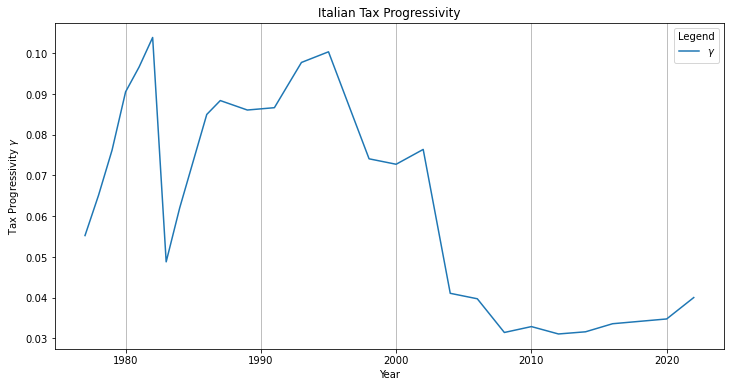

In [125]:
plt.figure(figsize=(12, 6))
plt.plot(df_g.index, df_g["Gamma"], label='$\gamma$')
plt.title('Italian Tax Progressivity')
plt.xlabel('Year')
plt.ylabel('Tax Progressivity $\gamma$')
plt.legend(title='Legend')
plt.grid(axis="x")

In [17]:
gibbs_df = pd.read_csv('updated_gamma.csv')
gibbs_df.loc[0, 'updateddata5'] = 2
gibbs_df = gibbs_df.loc[gibbs_df.index.repeat(4)].reset_index(drop=True)
gibbs_df['PR'] = gibbs_df['updateddata5'].apply(lambda x: "R" if x < 1.5 else "P")
df_q['PR_gibbs'] = gibbs_df['PR'].values


In [18]:
window = 4
df_q["PR"] = df_q["Gamma"].rolling(window=window).mean().shift(1) > df_q["Gamma"].rolling(window=window).mean().shift(-window)
df_q["PR"] = df_q["PR"].apply(lambda x: "R" if x else "P")
df_q["PR"].value_counts()

P    109
R     75
Name: PR, dtype: int64

In [19]:
df_q["PR_gibbs"].value_counts()

P    112
R     72
Name: PR_gibbs, dtype: int64

## Government Shock

In [20]:
dfMacro2 = pd.read_csv("Data/MacroVars2.csv", sep=";")
dfMacro2.rename(columns={"EmploymentRate (Total Employment / Total Population)": "Employment", "Unnamed: 0": "Time", "InterestRate (ten-year)": "IntRate", "Deflator (2020=100)": "Defl"}, inplace=True)
dfMacro2 = dfMacro2[["Time", "GDP", "TotalDirectExpenditure", "PrivateGDP", "Defl"]]
dfMacro2 = formatted_df(dfMacro2)

dfMacro2['Time'] = pd.PeriodIndex(dfMacro2['Time'], freq='Q').to_timestamp()
dfMacro2.set_index('Time', inplace=True)
dfMacro2.index = dfMacro2.index.to_period('Q')
dfMacro2.dropna(inplace=True)

toAdjustCols = ['GDP', 'PrivateGDP', 'TotalDirectExpenditure']
x12path = "/Users/gabrielvincenzi/Desktop/Economics/Thesis//x13as-mac-intel/bin"
dfMacro2 = tramo_seats(dfMacro2, to_adjust_cols=toAdjustCols, path=x12path, real=True, deflator="Defl")

dfMacrovars2 = pd.merge(dfMacro2[["Ln_PrivateGDP", "Ln_TotalDirectExpenditure"]], df_q["amtr"], left_index=True, right_index=True, how='inner')
dfMacrovars2.head()

,Ln_PrivateGDP,Ln_TotalDirectExpenditure,amtr
Time,,,
1996Q1,12.813450,11.270686,0.285293
1996Q2,12.703028,11.167856,0.285293
1996Q3,12.715735,11.179735,0.285293
1996Q4,12.674969,11.133554,0.285293
1997Q1,12.697041,11.135246,0.285906


In [165]:
#acf_residuals_plot(dfMacrovars2, model_lags=9, criterion='aic', figsize=(20,10))

In [166]:
lag = 9
model2 = VAR(dfMacrovars2)
results2 = model2.fit(lag, ic='aic')

U2 = results2.resid
g_shock2 = U2["Ln_TotalDirectExpenditure"]
g_shock2.name = "GShock"

dfSpending2 = pd.merge(dfMacro2[["Real_PrivateGDP", "Real_TotalDirectExpenditure"]], g_shock2, left_index=True, right_index=True, how='inner')
dfSpending2 = growth_attach(dfSpending2, columns=["Real_PrivateGDP", "Real_TotalDirectExpenditure"], lags=lag)
dfSpending2 = pd.merge(dfSpending2, df_q["amtr"], left_index=True, right_index=True, how='inner')

In [167]:
horizons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

horizonVars2 = horizon_dfs(
    starting_df=dfSpending2,
    horizons=horizons,
    column="Real_PrivateGDP",
    name= "Growth",
    columns_to_drop=["Real_PrivateGDP", "Real_TotalDirectExpenditure"],
    lags=lag
)

horizonVars2["Model_h0"] = horizonVars2[f"Model_h0"].drop(
    columns=["Growth_Real_PrivateGDP_l-1", "Growth_Real_TotalDirectExpenditure_l-1"]
)

multipliers2 = {}
p_values2 = {}
lower_bounds2 = {}
upper_bounds2 = {}

for h in horizons:
    y = horizonVars2[f"Model_h{h}"][f"Growth_h{h}"]
    x = horizonVars2[f"Model_h{h}"].drop(columns=[f"Growth_h{h}"])            
    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 1})
    multipliers2[f"{h}"] = model.params["GShock"]
    p_values2[f"{h}"] = model.pvalues["GShock"]
    lower_bounds2[f"{h}"] = model.conf_int()[0]["GShock"]
    upper_bounds2[f"{h}"] = model.conf_int()[1]["GShock"]

    #residuals = y - model.fittedvalues
    # Plot ACF and PACF
    #fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    #sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax[0])  # ACF plot
    #ax[0].set_title("ACF of Residuals")
    #sm.graphics.tsa.plot_pacf(residuals, lags=20, ax=ax[1])  # PACF plot
    #ax[1].set_title("PACF of Residuals")
    #plt.tight_layout()
    #plt.show()

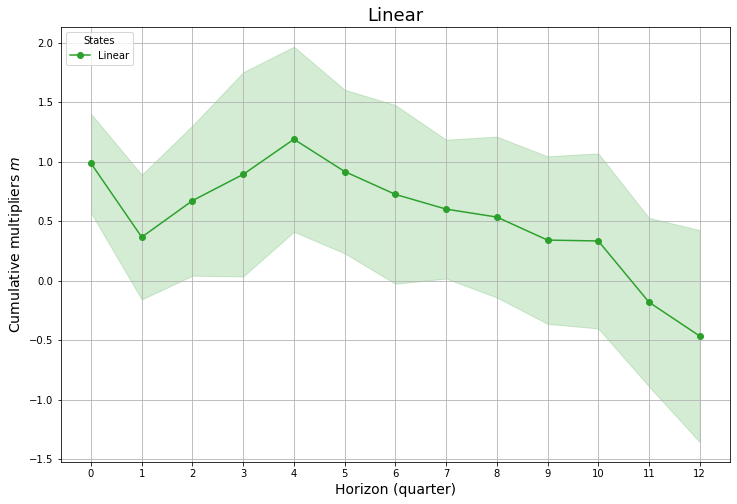

In [187]:
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
third_color = default_colors[2]

horizons = list(multipliers2.keys())
values = list(multipliers2.values())
lower = list(lower_bounds2.values())
upper = list(upper_bounds2.values())

# Create a plot
plt.figure(figsize=(12, 8))
plt.plot(horizons, values, marker='o', color=third_color, linestyle='-', label='Linear')
plt.fill_between(horizons, lower, upper, color=third_color, alpha=0.2)

# Add labels and title
plt.title("Linear", fontsize=18)
plt.xlabel("Horizon (quarter)", fontsize=14)
plt.ylabel("Cumulative multipliers $m$", fontsize=14)
plt.legend(title='States', fontsize=10, loc='upper left')
plt.grid(None)
# Show the plot
plt.show()

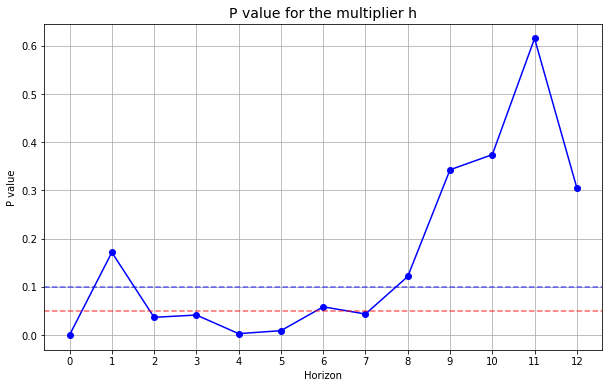

In [169]:
horizons = list(multipliers2.keys())
values = list(p_values2.values())

# Create a plot
plt.figure(figsize=(10, 6), frameon=True)
plt.plot(horizons, values, marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='red', alpha=0.6, linestyle='--', label='Rejection threshold 5%')
plt.axhline(y=0.10, color='blue', alpha=0.6, linestyle='--', label='Rejection threshold 10%')

# Add labels and title
plt.title("P value for the multiplier h", fontsize=14)
plt.xlabel("Horizon")
plt.ylabel("P value")
plt.grid(None)

# Show the plot
plt.show()

In [178]:
horizonVarsDummy = {}
for model in horizonVars2:
    horizonVarsDummy[model] = pd.merge(horizonVars2[model], df_q["PR"], on='Time', how="inner")
    dummy_df = pd.get_dummies(horizonVarsDummy[model]["PR"])
    horizonVarsDummy[model] = pd.concat([horizonVarsDummy[model], dummy_df], axis=1)
    horizonVarsDummy[model].drop(columns="PR", inplace=True)

    horizonVarsDummy[model] = sm.add_constant(horizonVarsDummy[model], has_constant='add')

    initial_cols = horizonVarsDummy[model].columns[:-2]
    initial_cols = [col for col in initial_cols if "Growth_h" not in col]

    for col in initial_cols:
        horizonVarsDummy[model][f"{col}_P"] = horizonVarsDummy[model][col] * horizonVarsDummy[model]["P"]
        horizonVarsDummy[model][f"{col}_R"] = horizonVarsDummy[model][col] * horizonVarsDummy[model]["R"]
        horizonVarsDummy[model].drop(columns=col, inplace=True)
    
    horizonVarsDummy[model].drop(columns=["P", "R"], inplace=True)


multipliers_P = {}
p_values_P = {}
lower_bounds_P = {}
upper_bounds_P = {}

multipliers_R = {}
p_values_R = {}
lower_bounds_R = {}
upper_bounds_R = {}


for h in horizons:
    y = horizonVarsDummy[f"Model_h{h}"][f"Growth_h{h}"]
    x = horizonVarsDummy[f"Model_h{h}"].drop(columns=[f"Growth_h{h}"])
    #X = sm.add_constant(x)

    model = sm.OLS(y, x).fit(cov_type="HAC", cov_kwds={"maxlags": 1})
    multipliers_P[f"{h}"] = model.params[f"GShock_P"]
    p_values_P[f"{h}"] = model.pvalues[f"GShock_P"]
    lower_bounds_P[f"{h}"] = model.conf_int()[0][f"GShock_P"]
    upper_bounds_P[f"{h}"] = model.conf_int()[1][f"GShock_P"]

    multipliers_R[f"{h}"] = model.params[f"GShock_R"]
    p_values_R[f"{h}"] = model.pvalues[f"GShock_R"]
    lower_bounds_R[f"{h}"] = model.conf_int()[0][f"GShock_R"]
    upper_bounds_R[f"{h}"] = model.conf_int()[1][f"GShock_R"]

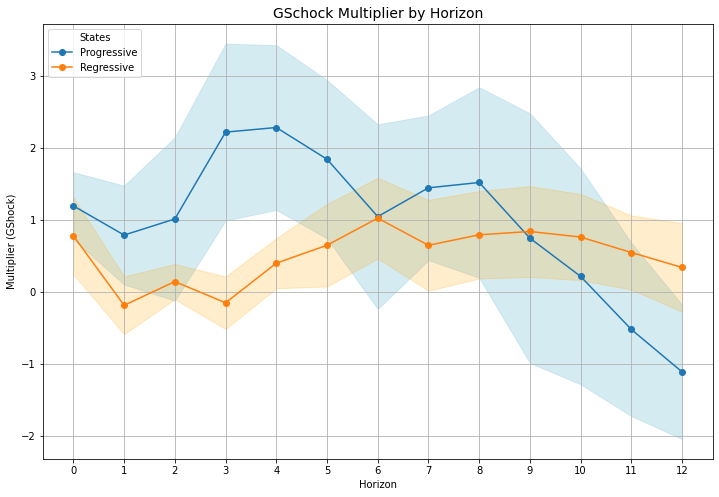

In [190]:
horizons_P = list(multipliers_P.keys())
values_P = list(multipliers_P.values())
lower_P = list(lower_bounds_P.values())
upper_P = list(upper_bounds_P.values())

horizons_R = list(multipliers_R.keys())
values_R = list(multipliers_R.values())
lower_R = list(lower_bounds_R.values())
upper_R = list(upper_bounds_R.values())

# Create a plot
plt.figure(figsize=(12, 8))
plt.plot(horizons_P, values_P, marker='o', linestyle='-', label='Progressive')
plt.fill_between(horizons_P, lower_P, upper_P, color='lightblue', alpha=0.5)

plt.plot(horizons_R, values_R, marker='o', linestyle='-', label='Regressive')
plt.fill_between(horizons_R, lower_R, upper_R, color='orange', alpha=0.2)

# Add labels and title
plt.title("GSchock Multiplier by Horizon", fontsize=14)
plt.xlabel("Horizon")
plt.ylabel("Multiplier (GShock)")
plt.legend(title='States', fontsize=10, loc='upper left')
plt.grid(None)

# Show the plot
plt.show()

In [180]:
z_score = 1.96  # for 95% confidence
se_P = [(upper - lower) / (2 * z_score) for upper, lower in zip(upper_P, lower_P)]
se_R = [(upper - lower) / (2 * z_score) for upper, lower in zip(upper_R, lower_R)]

z_stats = [(mean_P - mean_R) / np.sqrt(se_P_i**2 + se_R_i**2) for mean_P, mean_R, se_P_i, se_R_i in zip(values_P, values_R, se_P, se_R)]
p_values = [2 * (1 - norm.cdf(abs(z))) for z in z_stats]

for i, (z, p) in enumerate(zip(z_stats, p_values)):
    if p <= 0.05:
        print(f"Spending multiplier for horizon {i} is significant at 5%.")

Spending multiplier for horizon 1 is significant at 5%.
Spending multiplier for horizon 3 is significant at 5%.
Spending multiplier for horizon 4 is significant at 5%.
Spending multiplier for horizon 12 is significant at 5%.


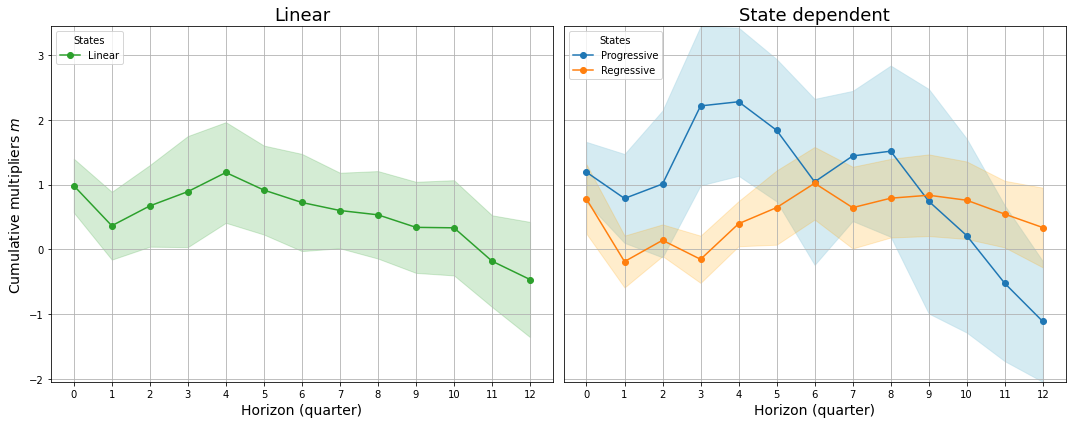

In [195]:
# Get third default color from Matplotlib's color cycle
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
third_color = default_colors[2]

# Data for the first plot
horizons = list(multipliers2.keys())
values = list(multipliers2.values())
lower = list(lower_bounds2.values())
upper = list(upper_bounds2.values())

# Data for the second plot
horizons_P = list(multipliers_P.keys())
values_P = list(multipliers_P.values())
lower_P = list(lower_bounds_P.values())
upper_P = list(upper_bounds_P.values())

horizons_R = list(multipliers_R.keys())
values_R = list(multipliers_R.values())
lower_R = list(lower_bounds_R.values())
upper_R = list(upper_bounds_R.values())

# Create side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# ---- First Plot ----
ax[0].plot(horizons, values, marker='o', color=third_color, linestyle='-', label='Linear')
ax[0].fill_between(horizons, lower, upper, color=third_color, alpha=0.2)
ax[0].set_title("Linear", fontsize=18)
ax[0].set_xlabel("Horizon (quarter)", fontsize=14)
ax[0].set_ylabel("Cumulative multipliers $m$", fontsize=14)
ax[0].legend(title='States', fontsize=10, loc='upper left')
ax[0].grid(None)

# ---- Second Plot ----
ax[1].plot(horizons_P, values_P, marker='o', linestyle='-', label='Progressive')
ax[1].fill_between(horizons_P, lower_P, upper_P, color='lightblue', alpha=0.5)

ax[1].plot(horizons_R, values_R, marker='o', linestyle='-', label='Regressive')
ax[1].fill_between(horizons_R, lower_R, upper_R, color='orange', alpha=0.2)

ax[1].set_title("State dependent", fontsize=18)
ax[1].set_xlabel("Horizon (quarter)", fontsize=14)
ax[1].legend(title='States', fontsize=10, loc='upper left')
ax[1].grid(None)

# ---- Set common y-axis limits ----
y_min = min(min(lower_P), min(lower_R))  # Lowest bound of second graph
y_max = max(max(upper_P), max(upper_R))  # Highest bound of second graph
ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

# ---- Remove y-ticks from the second plot ----
ax[1].set_yticklabels([])  # Removes y-axis labels
ax[1].tick_params(left=False)  # Removes y-axis ticks

# Adjust layout for better spacing
plt.tight_layout()

# Show both plots
plt.show()


# Inequality Measures

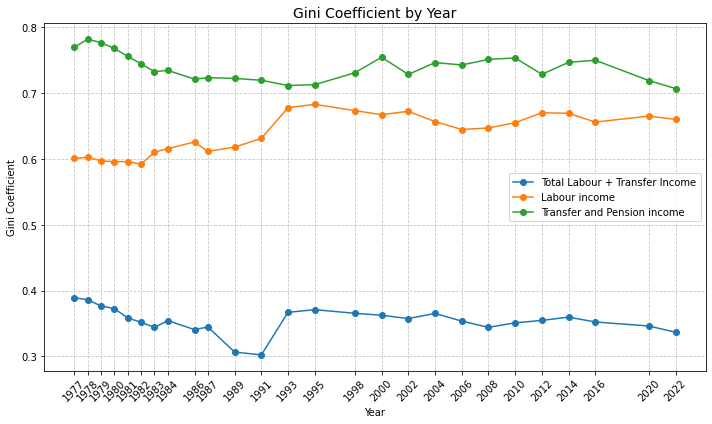

In [14]:
gini_results = []
for year, group in ind_df.groupby('ANNO'):
    gini_coeff_ylabour = gini(group['YLabour'].values, group['PESOPOP'].values)
    gini_coeff_yl = gini(group['YL'].values, group['PESOPOP'].values)
    gini_coeff_ym = gini(group['YM'].values, group['PESOPOP'].values)
    gini_coeff_yt = gini(group['YT'].values, group['PESOPOP'].values)
    gini_results.append({'ANNO': year, 'Gini_Ylabour': gini_coeff_ylabour, 'Gini_YL': gini_coeff_yl, 'Gini_YM': gini_coeff_ym, 'Gini_YT': gini_coeff_yt})

# Convert results to a DataFrame for plotting
gini_df = pd.DataFrame(gini_results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(gini_df['ANNO'], gini_df['Gini_Ylabour'], marker='o', label='Total Labour + Transfer Income')
plt.plot(gini_df['ANNO'], gini_df['Gini_YL'], marker='o', label='Labour income')
#plt.plot(gini_df['ANNO'], gini_df['Gini_YM'], marker='o', label='Self-employment income')
plt.plot(gini_df['ANNO'], gini_df['Gini_YT'], marker='o', label='Transfer and Pension income')
plt.xlabel('Year')
plt.ylabel('Gini Coefficient')
plt.title('Gini Coefficient by Year', fontsize=14)
plt.xticks(gini_df['ANNO'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

In [15]:
comp_fw = comp[comp["NORD"] <= 2][["NQUEST", "NORD", "ANNO", "ETA", "QUALP7N"]].copy()
comp_fw = comp_fw.groupby(['NQUEST', 'ANNO']).agg({'ETA': 'mean', 'QUALP7N': 'max'}).reset_index()
comp_fw = comp_fw.merge(weight[['NQUEST', 'ANNO', 'PESO', 'PESOPOP']], on=['NQUEST', 'ANNO'], how='left')

fw_df = ricf.merge(comp_fw, on=['NQUEST', 'ANNO'], how='inner')
fw_df.fillna(0, inplace=True)
fw_df['A'] = fw_df['AR'] + fw_df['AF']
fw_df['W'] = fw_df['A'] - fw_df['PF']

/var/folders/_s/3l81jppx5y5bjk_zkh9m6bdw0000gn/T/ipykernel_1269/2440427160.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /


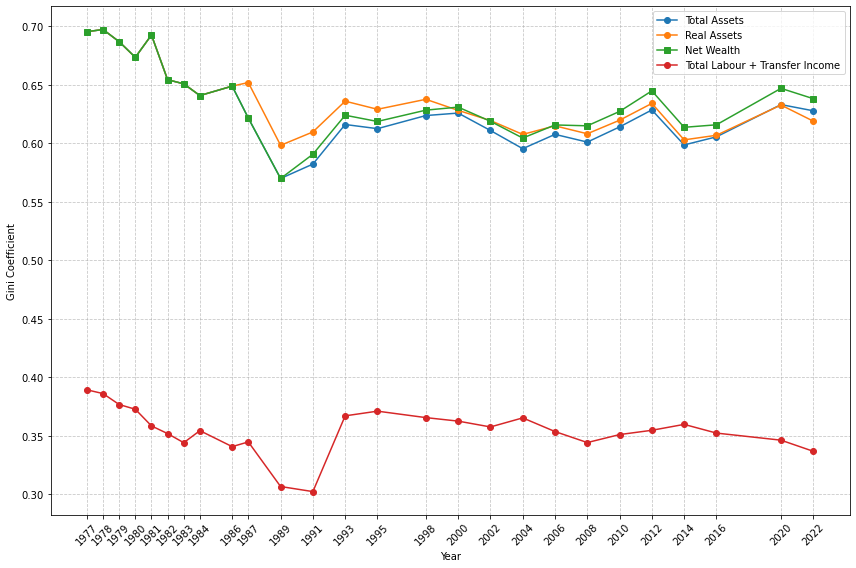

In [16]:
gini_results1 = []

# Group by year and calculate Gini coefficients
for year, group in fw_df.groupby('ANNO'):
    gini_coeff_a = gini(group['A'].values, group['PESOPOP'].values)
    gini_coeff_ar = gini(group['AR'].values, group['PESOPOP'].values)
    gini_coeff_af = gini(group['AF'].values, group['PESOPOP'].values)
    gini_coeff_w = gini(group['W'].values, group['PESOPOP'].values)
    gini_results1.append({'ANNO': year, 'Gini_A': gini_coeff_a, 'Gini_AR': gini_coeff_ar, 'Gini_AF': gini_coeff_af, 'Gini_W': gini_coeff_w})

# Convert results to a DataFrame for plotting
gini_df1 = pd.DataFrame(gini_results1)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(gini_df1['ANNO'], gini_df1['Gini_A'], marker='o', label='Total Assets')
plt.plot(gini_df1['ANNO'], gini_df1['Gini_AR'], marker='o', label='Real Assets')
#plt.plot(gini_df1['ANNO'], gini_df1['Gini_AF'], marker='o', label='Financial Assets')
plt.plot(gini_df1['ANNO'], gini_df1['Gini_W'], marker='s', label='Net Wealth')
plt.plot(gini_df['ANNO'], gini_df['Gini_Ylabour'], marker='o', label='Total Labour + Transfer Income')
plt.xlabel('Year')
plt.ylabel('Gini Coefficient')
#plt.title('Gini Coefficients for different Wealth Aggregates by Year', fontsize=14)
plt.xticks(gini_df1['ANNO'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

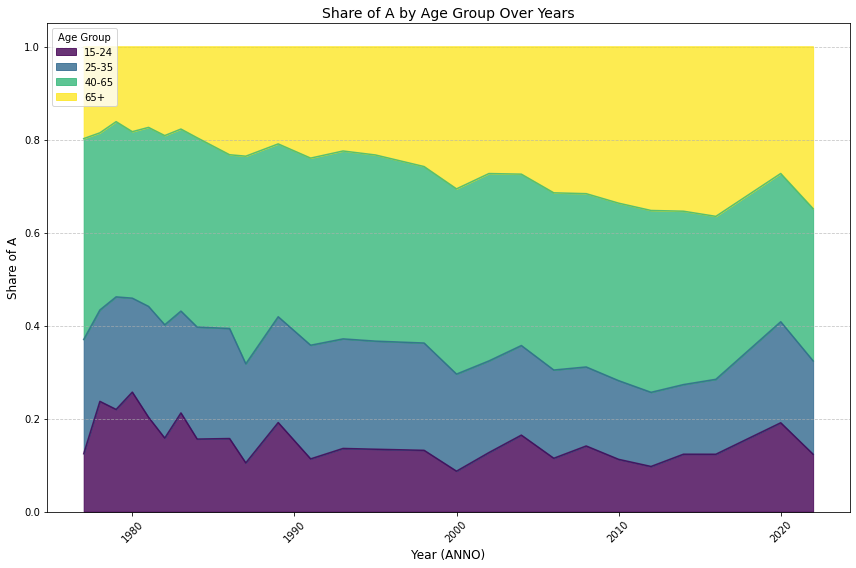

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define custom age bins and labels
age_bins = [15, 25, 36, 66, 100]  # 15-24, 25-35, 40-65, 65+
age_labels = ['15-24', '25-35', '40-65', '65+']

# Categorize ages
fw_df['Age_Group'] = pd.cut(fw_df['ETA'], bins=age_bins, labels=age_labels, right=False)

# Compute weighted average of 'A' by year (ANNO) and Age_Group
a_grouped = fw_df.groupby(['ANNO', 'Age_Group']).apply(
    lambda group: np.average(group['A'], weights=group['PESOPOP'])
).reset_index(name='A_weighted_avg')

# Pivot for area plot
a_pivot = a_grouped.pivot(index='ANNO', columns='Age_Group', values='A_weighted_avg')
a_shares = a_pivot.div(a_pivot.sum(axis=1), axis=0).fillna(0)

# Plot
a_shares.plot(kind='area', figsize=(12, 8), colormap='viridis', alpha=0.8)

# Customize plot
plt.title('Share of A by Age Group Over Years', fontsize=14)
plt.xlabel('Year (ANNO)', fontsize=12)
plt.ylabel('Share of A', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Age Group', fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
quantiles = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99] #[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
thresholds_A_df, bracketavg_A_df = get_income_quantiles(fw_df, quantiles, 'A')
bracketavg_A_df = bracketavg_A_df.fillna(0)
fw_df['Aperc'] = fw_df.apply(assign_percentile, axis=1, percentiles_df=bracketavg_A_df.set_index('ANNO'), variable='A')
fw_df['Aperc'] = fw_df['Aperc'].astype(int)

In [19]:
fw_df = fw_df.merge(defl[['Anno', 'DEFL']], left_on='ANNO', right_on='Anno', how='left')

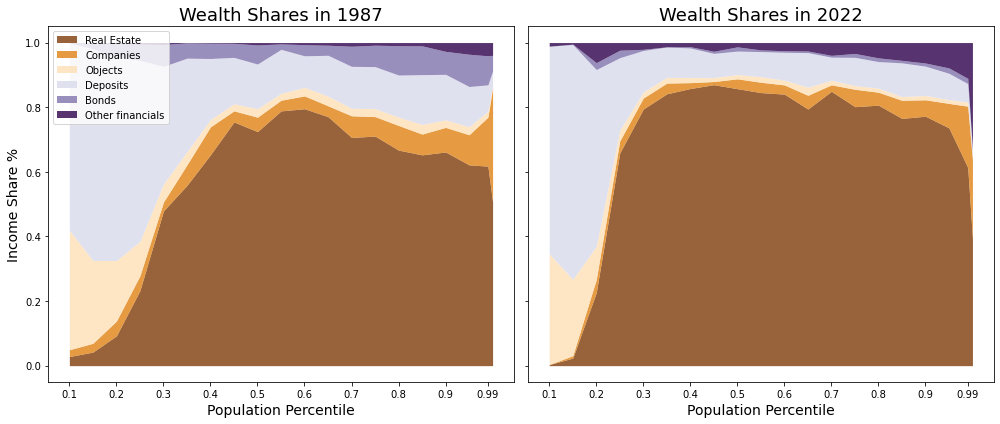

In [20]:
# Supponiamo che fw_df sia già definito e contenga i dati
years = [1987, 2022]
wealth_cols = ['AR1', 'AR2', 'AR3', 'AF1', 'AF2', 'AF3']
wealth_df = fw_df[['ANNO', 'PESOPOP', 'Aperc', 'DEFL'] + wealth_cols].copy()


# Contenitore per i dati aggregati
wealth_data = {}

for year in years:
    # Filtra i dati per l'anno specifico
    year_df = wealth_df.query("ANNO == @year").copy()
    
    # Calcola la ricchezza totale reale ponderata per la popolazione
    for col in wealth_cols:
        year_df[col] = (year_df[col] * year_df['PESOPOP']) / year_df['DEFL']
    
    # Riempie eventuali NaN con 0
    year_df = year_df.fillna(0)
    
    # Aggrega i dati per percentile di popolazione
    agg_data = year_df.groupby('Aperc')[wealth_cols].sum()
    agg_data['A'] = agg_data[wealth_cols].sum(axis=1)
    
    # Calcola le quote di ogni classe
    agg_data['Real Estate'] = agg_data['AR1'] / agg_data['A']
    agg_data['Companies'] = agg_data['AR2'] / agg_data['A']
    agg_data['Objects'] = agg_data['AR3'] / agg_data['A']
    agg_data['Deposits'] = agg_data['AF1'] / agg_data['A']
    agg_data['Bonds'] = agg_data['AF2'] / agg_data['A']
    agg_data['Other financials'] = agg_data['AF3'] / agg_data['A']
    
    # Salva i dati elaborati
    wealth_data[year] = agg_data

# Creazione dei grafici affiancati
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ticks = 2  # Adjust this based on how many x-ticks you want to show

wealth_data[1987].index = wealth_data[1987].index / 100
wealth_data[2022].index = wealth_data[2022].index / 100

# Plot for 1987
wealth_data[1987][['Real Estate', 'Companies', 'Objects', 'Deposits', 'Bonds', 'Other financials']].plot(kind='area', 
    ax=axes[0], colormap='PuOr', alpha=0.8, linewidth=0)
axes[0].set_title('Wealth Shares in 1987', fontsize=18)
axes[0].set_xlabel('Population Percentile', fontsize=14)
axes[0].set_ylabel('Income Share %', fontsize=14)
axes[0].set_xticks(wealth_data[1987].index[::ticks])  # Adjust frequency
axes[0].set_xticklabels(wealth_data[1987].index[::ticks], rotation=0)  # Match the ticks
axes[0].legend(loc='upper left')

# Plot for 2022
wealth_data[2022][['Real Estate', 'Companies', 'Objects', 'Deposits', 'Bonds', 'Other financials']].plot(kind='area', 
    ax=axes[1], colormap='PuOr', alpha=0.8, linewidth=0)
axes[1].set_title('Wealth Shares in 2022', fontsize=18)
axes[1].set_xlabel('Population Percentile', fontsize=14)
axes[1].set_xticks(wealth_data[2022].index[::ticks])  # Adjust frequency
axes[1].set_xticklabels(wealth_data[2022].index[::ticks], rotation=0)  # Match the ticks
axes[1].legend(loc='upper left').set_visible(False)

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


## Growth Curve Wealth

In [21]:
results = []

for year, group in fw_df.groupby('ANNO'):
    wealth = group['A'].values
    weights = group['PESOPOP'].values

    # Compute popsize and average
    popsize = np.sum(weights)
    average = np.average(wealth, weights=weights)

    # Compute thresholds and bracket averages
    thresholds, bracket_averages = weighted_quantile(wealth, quantiles, sample_weight=weights)

    # Append results for each quantile
    year_data = []
    for p, thr, bracketavg in zip(quantiles, thresholds, bracket_averages):
        year_data.append({
            'year': year,
            'country': 'Italy',
            'component': 'Wealth',
            'popsize': popsize,
            'average': average,
            'p': p,
            'thr': thr,
            'bracketavg': bracketavg
        })

    year_df = pd.DataFrame(year_data)
    year_df.to_csv(f"{year}_data.csv", index=False, sep=',')

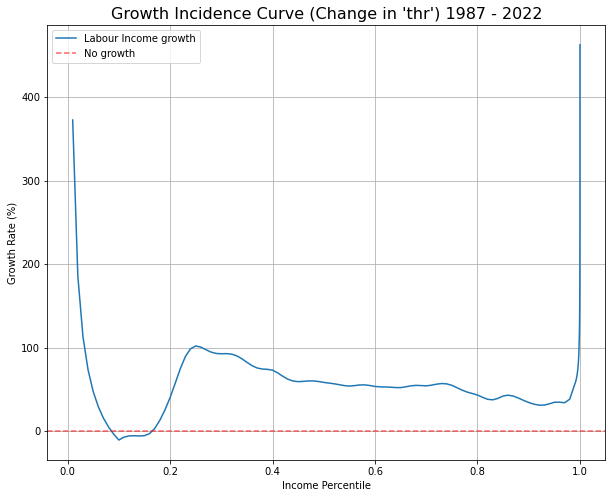

In [22]:
yearStart, yearEnd = 1987, 2022

# Generalized Pareto Interpolation distribution for YLabour
df_start = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoWealth/Wealth, Italy, 1987.csv')
df_end = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoWealth/Wealth, Italy, 2022.csv')

df_start = df_start[['p', 'thr', 'bracketavg']]
df_end = df_end[['p', 'thr', 'bracketavg']]

df_start['thr'] = df_start['thr'] / defl.query(f'Anno == {yearStart}')['DEFL'].values
df_end['thr'] = df_end['thr'] / defl.query(f'Anno == {yearEnd}')['DEFL'].values
df_start['bracketavg'] = df_start['bracketavg'] / defl.query(f'Anno == {yearStart}')['DEFL'].values
df_end['bracketavg'] = df_end['bracketavg'] / defl.query(f'Anno == {yearEnd}')['DEFL'].values

df_start.sort_values(by='p', inplace=True)
df_end.sort_values(by='p', inplace=True)

growth_w_df = pd.merge(df_start, df_end, on='p', how='inner')
growth_w_df['thr_diff'] = ((growth_w_df['thr_y'] - growth_w_df['thr_x']) / growth_w_df['thr_x']) * 100
growth_w_df['bracketavg_diff'] = ((growth_w_df['bracketavg_y'] - growth_w_df['bracketavg_x']) / growth_w_df['bracketavg_x']) * 100
growth_w_df.columns = ['Percentile', 'thr_start', 'bracketavg_start', 'thr_end', 'bracketavg_end', 'thr_growth', 'bracketavg_growth']



# Shiw data distribution
cols_tochange = [col for col in bracketavg_YL_df.columns if 'Q' in col]
datagrowth_df = pd.merge(bracketavg_YL_df, defl[['Anno', 'DEFL']], left_on='ANNO', right_on='Anno', how='inner')
datagrowth_df[cols_tochange] = datagrowth_df[cols_tochange].apply(lambda x: x / datagrowth_df['DEFL'], axis=0)
datagrowth_df = datagrowth_df.query(f'Anno == {yearStart} | Anno == {yearEnd}')
datagrowth_df = datagrowth_df.set_index('Anno')[cols_tochange].T.reset_index()
datagrowth_df['diff'] = ((datagrowth_df[yearEnd] - datagrowth_df[yearStart]) / datagrowth_df[yearStart]) * 100
datagrowth_df['index'] = quantiles

# Plot the Growth Incidence Curve
plt.figure(figsize=[10, 8])
plt.plot(growth_w_df['Percentile'], growth_w_df['thr_growth'], label='Labour Income growth')
#plt.plot(datagrowth_df['index'], datagrowth_df['diff'], label='Shiw growth')

plt.axhline(y=0, color='red', alpha=0.6, linestyle='--', label='No growth')
plt.title(f"Growth Incidence Curve (Change in 'thr') {yearStart} - {yearEnd}", fontsize=16)
plt.ylabel("Growth Rate (%)")
plt.xlabel("Income Percentile")
plt.legend()
plt.grid(True)
plt.show()


# Growth curve Income

In [23]:
yearStart, yearEnd = 1987, 2022

# Generalized Pareto Interpolation distribution for YLabour
df_start = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoInterp/Labor, Italy, {yearStart}.csv')
df_end = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoInterp/Labor, Italy, {yearEnd}.csv')

df_start = df_start[['p', 'thr', 'bracketavg']]
df_end = df_end[['p', 'thr', 'bracketavg']]

df_start['thr'] = df_start['thr'] / defl.query(f'Anno == {yearStart}')['DEFL'].values
df_end['thr'] = df_end['thr'] / defl.query(f'Anno == {yearEnd}')['DEFL'].values
df_start['bracketavg'] = df_start['bracketavg'] / defl.query(f'Anno == {yearStart}')['DEFL'].values
df_end['bracketavg'] = df_end['bracketavg'] / defl.query(f'Anno == {yearEnd}')['DEFL'].values

df_start.sort_values(by='p', inplace=True)
df_end.sort_values(by='p', inplace=True)

growth_df = pd.merge(df_start, df_end, on='p', how='inner')
growth_df['thr_diff'] = ((growth_df['thr_y'] - growth_df['thr_x']) / growth_df['thr_x']) * 100
growth_df['bracketavg_diff'] = ((growth_df['bracketavg_y'] - growth_df['bracketavg_x']) / growth_df['bracketavg_x']) * 100
growth_df.columns = ['Percentile', 'thr_start', 'bracketavg_start', 'thr_end', 'bracketavg_end', 'thr_growth', 'bracketavg_growth']


# Generalized Pareto Interpolation distribution for Y1
df_start_Y1 = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoInterpY1/Labor, Italy, {yearStart}.csv')
df_end_Y1 = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoInterpY1/Labor, Italy, {yearEnd}.csv')

df_start_Y1 = df_start_Y1[['p', 'thr', 'bracketavg']]
df_end_Y1 = df_end_Y1[['p', 'thr', 'bracketavg']]

df_start_Y1['thr'] = df_start_Y1['thr'] / defl.query(f'Anno == {yearStart}')['DEFL'].values
df_end_Y1['thr'] = df_end_Y1['thr'] / defl.query(f'Anno == {yearEnd}')['DEFL'].values
df_start_Y1['bracketavg'] = df_start_Y1['bracketavg'] / defl.query(f'Anno == {yearStart}')['DEFL'].values
df_end_Y1['bracketavg'] = df_end_Y1['bracketavg'] / defl.query(f'Anno == {yearEnd}')['DEFL'].values

df_start_Y1.sort_values(by='p', inplace=True)
df_end_Y1.sort_values(by='p', inplace=True)

growth_df_Y1 = pd.merge(df_start_Y1, df_end_Y1, on='p', how='inner')
growth_df_Y1['thr_diff'] = ((growth_df_Y1['thr_y'] - growth_df_Y1['thr_x']) / growth_df_Y1['thr_x']) * 100
growth_df_Y1['bracketavg_diff'] = ((growth_df_Y1['bracketavg_y'] - growth_df_Y1['bracketavg_x']) / growth_df_Y1['bracketavg_x']) * 100
growth_df_Y1.columns = ['Percentile', 'thr_start', 'bracketavg_start', 'thr_end', 'bracketavg_end', 'thr_growth', 'bracketavg_growth']


# Means
weighted_avg_ylabour = ind_df.groupby('ANNO').apply(
    lambda group: np.average(group['Y1_real'], weights=group['PESOPOP'])
).reset_index(name='Y1_weighted_avg')

mean_start_l = weighted_avg_ylabour[weighted_avg_ylabour['ANNO'] == yearStart]['Y1_weighted_avg'].values
mean_end_l = weighted_avg_ylabour[weighted_avg_ylabour['ANNO'] == yearEnd]['Y1_weighted_avg'].values

mean_l = (mean_end_l - mean_start_l)  / mean_start_l * 100

fw_df['A_real'] = fw_df['A'] / fw_df['DEFL']

wa_wealth = fw_df.groupby('ANNO').apply(
    lambda group: np.average(group['A_real'], weights=group['PESOPOP'])
).reset_index(name='A_weighted_avg')

mean_start_w = wa_wealth[wa_wealth['ANNO'] == 1987]['A_weighted_avg'].values
mean_end_w = wa_wealth[wa_wealth['ANNO'] == 2022]['A_weighted_avg'].values

mean_w = (mean_end_w - mean_start_w)  / mean_start_w * 100

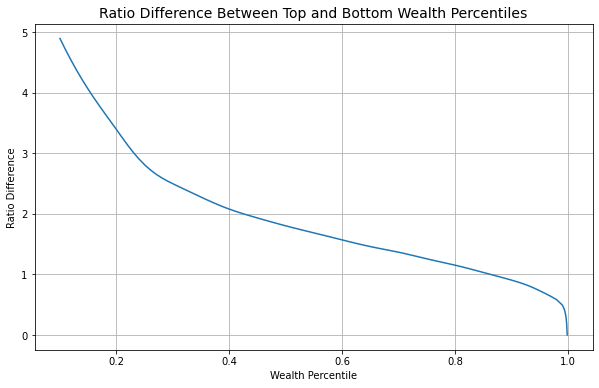

In [24]:
# Define the range of percentiles
percentiles = range(10, 109)  # From 10 to 108

# Initialize lists to store the computed values
ratio_diffs = []
x_values = []  # Stores corresponding percentiles from the dataframe

# Compute ratio_diff for each percentile
for bottom in percentiles:
    top = 108  # Fixed top percentile position (99.9th percentile)
    
    bottom_start = growth_df_Y1.iloc[bottom]['thr_start']
    bottom_end = growth_df_Y1.iloc[bottom]['thr_end']
    top_start = growth_df_Y1.iloc[top]['thr_start']
    top_end = growth_df_Y1.iloc[top]['thr_end']
    
    diff_start = top_start - bottom_start  # Difference rich to poor (initial)
    diff_end = top_end - bottom_end        # Difference rich to poor (final)
    diff = diff_end - diff_start           # Change in difference
    ratio_diff = diff / bottom_start       # Ratio of difference change to initial bottom wealth
    
    ratio_diffs.append(ratio_diff)
    x_values.append(growth_df_Y1.iloc[bottom]['Percentile'])  # Store actual percentile values

# Convert to DataFrame for plotting
df_ratio = pd.DataFrame({'Percentile': x_values, 'Ratio_Diff': ratio_diffs})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_ratio['Percentile'], df_ratio['Ratio_Diff'], linestyle='-')

plt.title("Ratio Difference Between Top and Bottom Wealth Percentiles", fontsize=14)
plt.xlabel("Wealth Percentile")
plt.ylabel("Ratio Difference")
plt.grid(True)
plt.show()


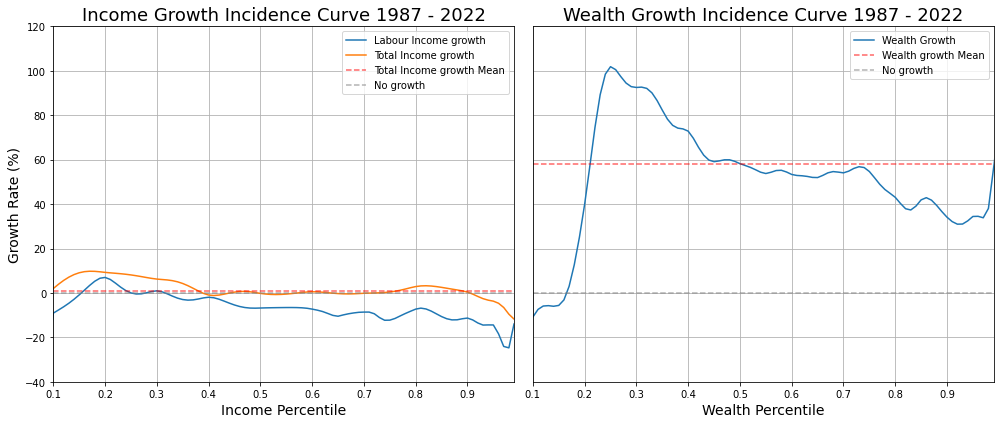

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Two subplots in one row

# First plot: Growth Incidence Curve for Labour and Total Income
ax[0].plot(growth_df['Percentile'], growth_df['thr_growth'], label='Labour Income growth')
ax[0].plot(growth_df_Y1['Percentile'], growth_df_Y1['thr_growth'], label='Total Income growth')
ax[0].axhline(y=mean_l, color='red', alpha=0.6, linestyle='--', label='Total Income growth Mean')
ax[0].axhline(y=0, color='grey', alpha=0.6, linestyle='--', label='No growth')

ax[0].set_title(f"Income Growth Incidence Curve {yearStart} - {yearEnd}", fontsize=18)
ax[0].set_ylabel("Growth Rate (%)", fontsize=14)
ax[0].set_xlabel("Income Percentile", fontsize=14)
ax[0].set_xlim(0.1, 0.99)  # Limit x-axis
ax[0].set_ylim(-40, 120)  # Limit x-axis
ax[0].legend()
ax[0].grid(True)

# Second plot: Growth Incidence Curve for Wealth
ax[1].plot(growth_w_df['Percentile'], growth_w_df['thr_growth'], label='Wealth Growth')
ax[1].axhline(y=mean_w, color='red', alpha=0.6, linestyle='--', label='Wealth growth Mean')
ax[1].axhline(y=0, color='grey', alpha=0.6, linestyle='--', label='No growth')

ax[1].set_title(f"Wealth Growth Incidence Curve 1987 - {yearEnd}", fontsize=18)
ax[1].set_xlabel("Wealth Percentile", fontsize=14)
ax[1].tick_params(left=False, labelleft=False)
ax[1].set_xlim(0.1, 0.99)  # Limit x-axis
ax[1].set_ylim(-40, 120)
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

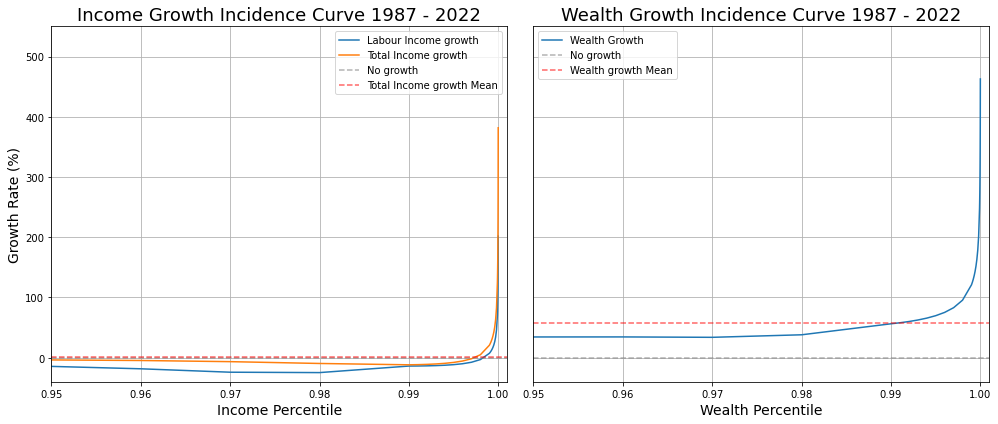

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Two subplots in one row

# First plot: Growth Incidence Curve for Labour and Total Income
ax[0].plot(growth_df['Percentile'], growth_df['thr_growth'], label='Labour Income growth')
ax[0].plot(growth_df_Y1['Percentile'], growth_df_Y1['thr_growth'], label='Total Income growth')
ax[0].axhline(y=0, color='grey', alpha=0.6, linestyle='--', label='No growth')
ax[0].axhline(y=mean_l, color='red', alpha=0.6, linestyle='--', label='Total Income growth Mean')
ax[0].set_title(f"Income Growth Incidence Curve {yearStart} - {yearEnd}", fontsize=18)
ax[0].set_ylabel("Growth Rate (%)", fontsize=14)
ax[0].set_xlabel("Income Percentile", fontsize=14)
ax[0].set_xlim(0.95, 1)  # Limit x-axis
ax[0].set_ylim(-40, 550)  # Limit x-axis
ax[0].legend()
ax[0].grid(True)

# Second plot: Growth Incidence Curve for Wealth
ax[1].plot(growth_w_df['Percentile'], growth_w_df['thr_growth'], label='Wealth Growth')
ax[1].axhline(y=0, color='grey', alpha=0.6, linestyle='--', label='No growth')
ax[1].axhline(y=mean_w, color='red', alpha=0.6, linestyle='--', label='Wealth growth Mean')
ax[1].set_title(f"Wealth Growth Incidence Curve 1987 - {yearEnd}", fontsize=18)
ax[1].set_xlabel("Wealth Percentile", fontsize=14)
ax[1].tick_params(left=False, labelleft=False)
ax[1].set_xlim(0.95, 1)  # Limit x-axis
ax[1].set_ylim(-40, 550)
ax[1].legend()
ax[1].grid(True)

ax[0].set_xlim(0.95, 1.001)
ax[1].set_xlim(0.95, 1.001)

# Hide the last tick (1.005) to keep percentile distribution clean
ax[0].set_xticks([0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
ax[1].set_xticks([0.95, 0.96, 0.97, 0.98, 0.99, 1.00])

#

plt.tight_layout()  # Adjust layout for better spacing
plt.show()



# Income measures and shares

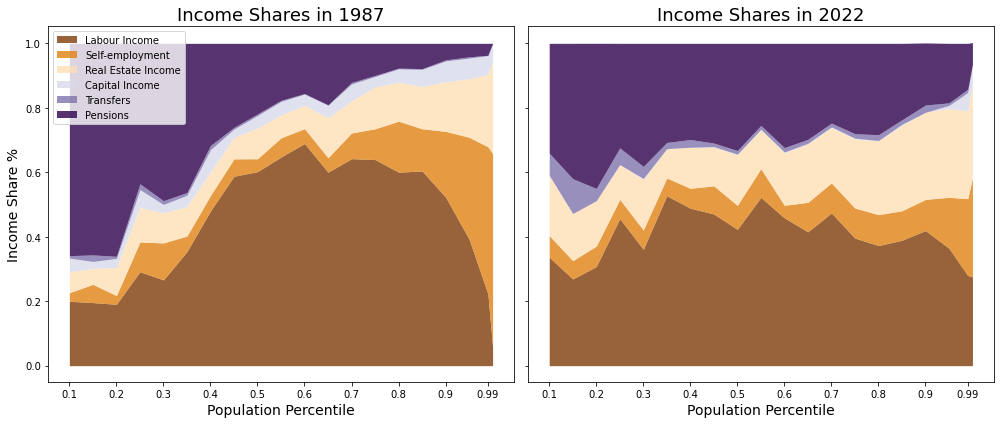

In [27]:
years = [1987, 2022]
ticks = 2
income_cols = ['Y1', 'YL', 'YM', 'YT', 'YTA', 'YTP', 'YCA', 'YCF']
income_df = ind_df[['ANNO', 'PESOPOP', 'Y1perc'] + income_cols].copy()

# Initialize a container for data from both years
shares_all = {}

for year in years:
    # Filter data for the specific year (ensure a copy to avoid SettingWithCopyWarning)
    year_df = income_df.query("ANNO == @year").copy()
    total_pop = year_df['PESOPOP'].sum()
    
    # Modify columns explicitly using .loc to avoid SettingWithCopyWarning
    for col in income_cols:
        year_df.loc[:, col] = year_df[col] * year_df['PESOPOP']
    
    # Use fillna safely (no inplace to avoid warnings)
    year_df = year_df.fillna(0)
    
    # Aggregate data by 'Y1perc'
    agg_data = year_df.groupby('Y1perc')[income_cols].sum()
    agg_data['Y'] = agg_data[['YL', 'YM', 'YCA', 'YCF', 'YTA', 'YTP']].sum(axis=1)
    agg_data['Labour Income'] = agg_data['YL'] / agg_data['Y']
    agg_data['Real Estate Income'] = agg_data['YCA'] / agg_data['Y']
    agg_data['Capital Income'] = np.where(agg_data['YCF'] >= 0, agg_data['YCF'] / agg_data['Y'], 0)
    agg_data['Transfers'] = np.where(agg_data['YTA'] >= 0, agg_data['YTA'] / agg_data['Y'], 0)
    agg_data['Pensions'] = agg_data['YTP'] / agg_data['Y']
    agg_data['Self-employment'] = agg_data['YM'] / agg_data['Y']
    
    # Store the shares for this year
    shares_all[year] = agg_data[['Labour Income', 'Self-employment', 'Real Estate Income', 'Capital Income', 'Transfers', 'Pensions']]

shares_all[1987].index = shares_all[1987].index / 100
shares_all[2022].index = shares_all[2022].index / 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for 1987
shares_all[1987].plot(kind='area', ax=axes[0], colormap='PuOr', alpha=0.8, linewidth=0)
axes[0].set_title('Income Shares in 1987', fontsize=18)
axes[0].set_xlabel('Population Percentile', fontsize=14)
axes[0].set_ylabel('Income Share %', fontsize=14)

# Set more x-ticks
axes[0].set_xticks(shares_all[1987].index[::ticks])  # Adjust frequency (every 5th index)
axes[0].set_xticklabels(shares_all[1987].index[::ticks], rotation=0)  # Match the ticks
axes[0].legend(loc='upper left')

# Plot for 2022
shares_all[2022].plot(kind='area', ax=axes[1], colormap='PuOr', alpha=0.8, linewidth=0)
axes[1].set_title('Income Shares in 2022', fontsize=18)
axes[1].set_xlabel('Population Percentile', fontsize=14)

# Set more x-ticks
axes[1].set_xticks(shares_all[2022].index[::ticks])  # Adjust frequency (every 5th index)
axes[1].set_xticklabels(shares_all[2022].index[::ticks], rotation=0)  # Match the ticks
axes[1].legend(loc='upper left').set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

In [28]:
years = [1987, 2022]
filtered_df = ind_df.query("ANNO in @years")
agg_data = filtered_df.groupby(['ANNO', 'Yperc'])[income_cols + ['PESOPOP']].sum()

for col in income_cols:
    agg_data[col] = agg_data[col] * agg_data['PESOPOP'] #/ total_pop

# Step 3: Calculate total income and shares for each year
agg_data['Y'] = agg_data[['YL', 'YM', 'YCA', 'YCF', 'YT']].sum(axis=1)
agg_data['YL_share'] = agg_data['YL'] / agg_data['Y']
agg_data['YCA_share'] = agg_data['YCA'] / agg_data['Y']
agg_data['YCF_share'] = agg_data['YCF'] / agg_data['Y']
agg_data['YT_share'] = agg_data['YT'] / agg_data['Y']
agg_data['YM_share'] = agg_data['YM'] / agg_data['Y']
agg_data = agg_data.reset_index()

pivot_data = agg_data.pivot(index='Yperc', columns='ANNO', values=['YL_share', 'YCA_share', 'YCF_share', 'YT_share', 'YM_share'])

growth_data = (pivot_data.xs(2022, level=1, axis=1) - pivot_data.xs(1987, level=1, axis=1))
growth_data.columns = ['YL Growth', 'YCA Growth', 'YCF Growth', 'YT Growth', 'YM Growth']
growth_data

,YL Growth,YCA Growth,YCF Growth,YT Growth,YM Growth
Yperc,,,,,
10,-0.059035,0.278218,-0.060499,-0.164537,0.005854
15,0.152566,0.065231,-0.057014,-0.208379,0.047596
20,0.033249,0.084420,-0.042135,-0.047215,-0.028319
25,0.005650,0.123674,-0.045994,-0.134674,0.051345
30,-0.108058,0.095137,-0.036695,0.101641,-0.052025
35,-0.027931,0.082260,-0.033488,0.061791,-0.082632
40,-0.073551,0.089463,-0.032695,-0.002616,0.019399
45,0.108734,0.076092,-0.047894,-0.215041,0.078109
50,-0.081703,0.072297,-0.037090,0.071833,-0.025337


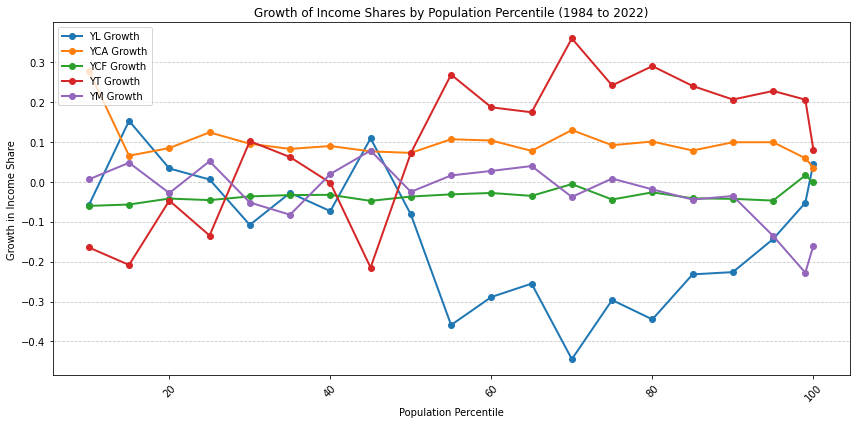

In [29]:
growth_data.plot(kind='line', figsize=(12, 6), linewidth=2, marker='o')
plt.title('Growth of Income Shares by Population Percentile (1984 to 2022)')
plt.xlabel('Population Percentile')
plt.ylabel('Growth in Income Share')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Income / Wealth Ratios

In [124]:
ind_df[['NQUEST','NORD', 'Y1']]

,NQUEST,NORD,Y1
0,1,1,1586.555594
1,2,1,530.401235
2,2,2,774.685349
3,3,1,2530.638806
4,3,2,1626.839232
...,...,...,...
295725,1072961,1,14200.000000
295726,1072961,2,7000.000000
295728,1072969,1,25200.000000
295729,1072970,1,192500.000000


In [125]:
grouped_ind_df = ind_df.groupby(['NQUEST', 'ANNO'], as_index=False).agg({
    'Y1': 'sum',
    'YT': 'sum',
    'YC': 'sum',
    'YM': 'sum',
    'YL': 'sum',
    'YLabour': 'sum',
    'PESOPOP': 'first',
})

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
thresholds_Y1_df, bracketavg_Y1_df = get_income_quantiles(grouped_ind_df, quantiles, 'YLabour')
grouped_ind_df['YLabourPerc'] = grouped_ind_df.apply(assign_percentile, axis=1, percentiles_df=bracketavg_Y1_df.set_index('ANNO'), variable='YLabour')
grouped_ind_df['YLabourPerc'] = grouped_ind_df['YLabourPerc'].astype(int)

wi_df = pd.merge(grouped_ind_df, fw_df, on=['NQUEST', 'ANNO'], how='inner')
wi_df['w/i'] = wi_df['A'] / wi_df['YLabour']

In [126]:
wi_df.head()

,NQUEST,ANNO,Y1,YT,YC,YM,YL,YLabour,PESOPOP_x,YLabourPerc,...,QUALP7N,PESO,PESOPOP_y,A,Age_Group,Aperc,Anno,DEFL,A_real,w/i
0,1,1977,1586.555594,1369.643696,216.911898,0.000000,0.000000,1369.643696,4778.056035,20,...,0.0,0.838328,4778.056035,7746.853486,40-65,55,1977,0.122842,63063.356054,5.656109
1,1,1978,3098.741394,0.000000,0.000000,3098.741394,0.000000,3098.741394,5736.395098,50,...,0.0,1.047285,5736.395098,0.000000,40-65,10,1978,0.137855,0.000000,0.000000
2,1,1979,2633.930185,2014.181906,619.748279,0.000000,0.000000,2014.181906,6115.079244,20,...,0.0,1.032070,6115.079244,18075.991468,40-65,65,1979,0.159235,113517.705047,8.974359
3,1,1980,1162.028023,0.000000,0.000000,0.000000,1162.028023,1162.028023,10693.231389,10,...,0.0,1.860654,10693.231389,0.000000,25-35,10,1980,0.191813,0.000000,0.000000
4,1,1981,5448.620285,0.000000,0.000000,0.000000,5448.620285,5448.620285,1355.293275,50,...,0.0,0.317864,1355.293275,0.000000,40-65,10,1981,0.226386,0.000000,0.000000


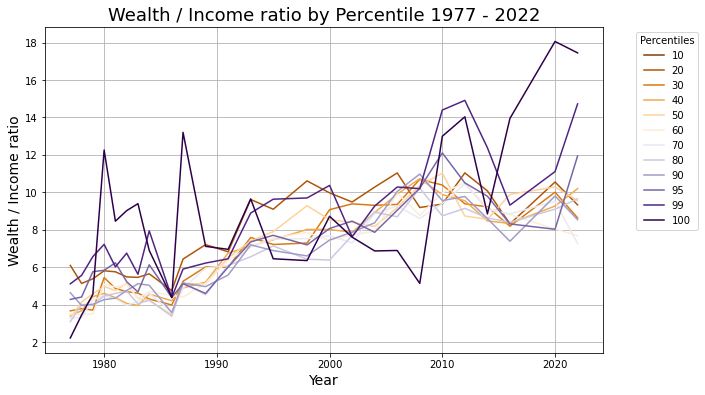

In [127]:
agg_df = wi_df.groupby(['ANNO', 'YLabourPerc']).apply(
    lambda x: (x['w/i'] * x['PESOPOP_x']).sum() / x['PESOPOP_x'].sum()
).reset_index(name='Weighted_wi')

# Get unique percentiles in sorted order
percentiles = sorted(agg_df['YLabourPerc'].unique())
colors = cm.PuOr(np.linspace(0, 1, len(percentiles)))

plt.figure(figsize=(10, 6))

# Plot each percentile's weighted average over time
for i, perc in enumerate(percentiles):
    subset = agg_df[agg_df['YLabourPerc'] == perc]
    plt.plot(subset['ANNO'], subset['Weighted_wi'], label=f'{perc}', color=colors[i])

# Labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Wealth / Income ratio', fontsize=14)
plt.title('Wealth / Income ratio by Percentile 1977 - 2022', fontsize=18)

# Legend and grid
plt.legend(title='Percentiles', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

# Education measurements

In [128]:
cfred_wages = ind_df[ind_df['CFRED'] == 1][['NQUEST', 'Yperc']]
family_wage_map = cfred_wages.groupby('NQUEST')['Yperc'].first().to_dict()
ind_df['Yperc_parent'] = ind_df['NQUEST'].map(family_wage_map)

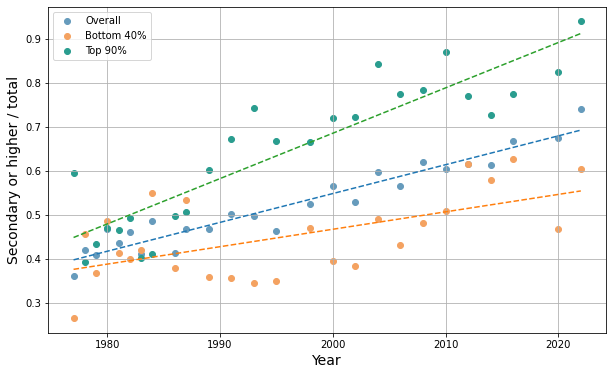

In [129]:
study_level, bottom_share, top_share = 4, 40, 90

shiw_df = ind_df[["ANNO", "STUDIO", "Yperc_parent", "PESOPOP", "ETA"]]
shiw_df = shiw_df.dropna()
shiw_df = shiw_df[(shiw_df["ETA"] >= 19) & (shiw_df["ETA"] <= 26)]
shiw_df['STUDIO'] = pd.to_numeric(shiw_df['STUDIO'])
shiw_df["stud"] = (shiw_df['STUDIO'] >= study_level).astype(int)

shiw_df['Yperc_parent'] = pd.to_numeric(shiw_df['Yperc_parent'])
shiw_bottom = shiw_df[shiw_df["Yperc_parent"] <= bottom_share]
shiw_top = shiw_df[shiw_df["Yperc_parent"] >= top_share]

prop_stud = shiw_df.groupby("ANNO").apply(lambda group: ((group["stud"] * group["PESOPOP"]).sum() / group["PESOPOP"].sum()).sum())
prop_stud_bottom = shiw_bottom.groupby("ANNO").apply(lambda group: ((group["stud"] * group["PESOPOP"]).sum() / group["PESOPOP"].sum()).sum())
prop_stud_top = shiw_top.groupby("ANNO").apply(lambda group: ((group["stud"] * group["PESOPOP"]).sum() / group["PESOPOP"].sum()).sum())

#prop_stud = shiw_df.groupby("ANNO").apply(lambda group: (group["stud"] * group["PESOPOP"] / group["PESOPOP"].sum()).sum())
#prop_stud_bottom = shiw_bottom.groupby("ANNO").apply(lambda group: (group["stud"] * group["PESOPOP"] / group["PESOPOP"].sum()).sum())
#prop_stud_top = shiw_top.groupby("ANNO").apply(lambda group: (group["stud"] * group["PESOPOP"] / group["PESOPOP"].sum()).sum())

years = shiw_df["ANNO"].unique()
years_numeric = np.array(years)

# Compute regression lines
coeff_stud = np.polyfit(years_numeric, prop_stud, 1)
coeff_stud_bottom = np.polyfit(years_numeric, prop_stud_bottom, 1)
coeff_stud_top = np.polyfit(years_numeric, prop_stud_top, 1)

# Generate regression line values
line_stud = np.polyval(coeff_stud, years_numeric)
line_stud_bottom = np.polyval(coeff_stud_bottom, years_numeric)
line_stud_top = np.polyval(coeff_stud_top, years_numeric)

# Plot the scatter plots
plt.figure(figsize=(10, 6), frameon=True)
plt.scatter(years, prop_stud, color='#669bbc', label="Overall")
plt.scatter(years, prop_stud_bottom, color='#f4a261', label=f"Bottom {bottom_share}%")
plt.scatter(years, prop_stud_top, color='#2a9d8f', label=f"Top {top_share}%")

# Plot regression lines
plt.plot(years_numeric, line_stud, linestyle='--')
plt.plot(years_numeric, line_stud_bottom, linestyle='--')
plt.plot(years_numeric, line_stud_top, linestyle='--')

# Plot regression lines
#plt.plot(years_numeric, line_stud, color='#669bbc', linestyle='--')
#plt.plot(years_numeric, line_stud_bottom, color='#f4a261', linestyle='--')
#plt.plot(years_numeric, line_stud_top, color='#2a9d8f', linestyle='--')

# Add titles and labels
#plt.title("Proportion of Individuals with Secondary School or Higher by Family Percentile", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Secondary or higher / total", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [130]:
fami_df = fami[["ANNO", "NQUEST", "stupcf", "stumcf", "stupco", "stumco"]]
parents_df = ind_df[ind_df["NORD"] <= 2][["NQUEST", "NORD", "ANNO", "STUDIO", "PESOPOP"]].copy()
parents_df['STUDIOF'] = None
parents_df['STUDIOM'] = None

parents_df = pd.merge(parents_df, fami_df, on=["NQUEST", "ANNO"], how="inner")
parents_df['STUDIOF'] = np.where(parents_df['NORD'] == 1, parents_df['stupcf'], np.where(parents_df['NORD'] == 2, parents_df['stupco'], None))
parents_df['STUDIOM'] = np.where(parents_df['NORD'] == 1, parents_df['stumcf'], np.where(parents_df['NORD'] == 2, parents_df['stumco'], None))
parents_df['PARENTSTUDIO'] = np.maximum(parents_df['STUDIOF'], parents_df['STUDIOM'])
parents_df.drop(columns=["stupcf", "stumcf", "stupco", "stumco"], inplace=True)

probability_tables = {}
unique_years = parents_df['ANNO'].unique()

for year in unique_years:
    yearly_data = parents_df[parents_df['ANNO'] == year]
    
    # Create the contingency table for the current year
    contingency_table = pd.crosstab(
        index=yearly_data['PARENTSTUDIO'], 
        columns=yearly_data['STUDIO'], 
        values=yearly_data['PESOPOP'],  # Use PESO as weights
        aggfunc='sum',               # Sum up the weights
        margins=False                 # Include margins for totals
    )
    if 7.0 in contingency_table.index:  # Check if 7.0 exists in the row index
        contingency_table.drop(index=[7.0], inplace=True)
    
    # Calculate probabilities by normalizing the contingency table
    probability_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    
    # Store the probability table in the dictionary with the year as key
    probability_tables[year] = probability_table

In [131]:
unique_years

array([1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1986, 1987, 1989,
       1991, 1993, 1995, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012,
       2014, 2016, 2020, 2022])

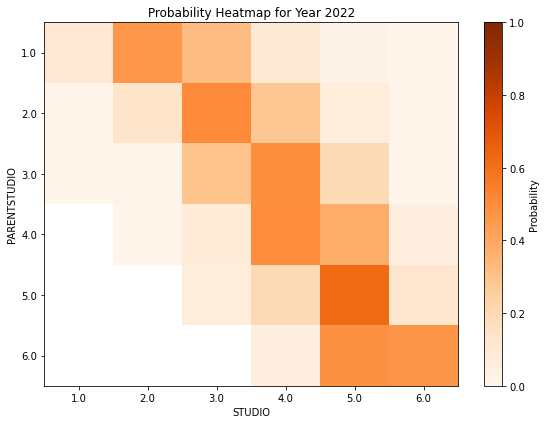

In [132]:
year_to_visualize = 2022

if year_to_visualize in probability_tables:
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # Create heatmap using plt.imshow()
    plt.imshow(probability_tables[year_to_visualize], cmap='Oranges', aspect='auto', vmin=0, vmax=1)
    
    # Add color bar
    plt.colorbar(label='Probability')

    # Set ticks and labels
    plt.xticks(ticks=np.arange(len(probability_tables[year_to_visualize].columns)), 
               labels=probability_tables[year_to_visualize].columns)
    plt.yticks(ticks=np.arange(len(probability_tables[year_to_visualize].index)), 
               labels=probability_tables[year_to_visualize].index)
    
    plt.title(f'Probability Heatmap for Year {year_to_visualize}')
    plt.xlabel('STUDIO')
    plt.ylabel('PARENTSTUDIO')
    
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()
else:
    print(f"No data available for year {year_to_visualize}.")

In [133]:
probability_tables[2022]

STUDIO,1.0,2.0,3.0,4.0,5.0,6.0
PARENTSTUDIO,,,,,,
1.0,0.105445,0.459708,0.318401,0.099981,0.014338,0.002127
2.0,0.002525,0.134350,0.509248,0.282665,0.067360,0.003853
3.0,0.000157,0.008615,0.296305,0.494277,0.191659,0.008986
4.0,NaN,0.000686,0.075901,0.496837,0.375454,0.051121
5.0,NaN,NaN,0.066701,0.191435,0.618968,0.122896
6.0,NaN,NaN,NaN,0.052221,0.482481,0.465299


# Age measurements

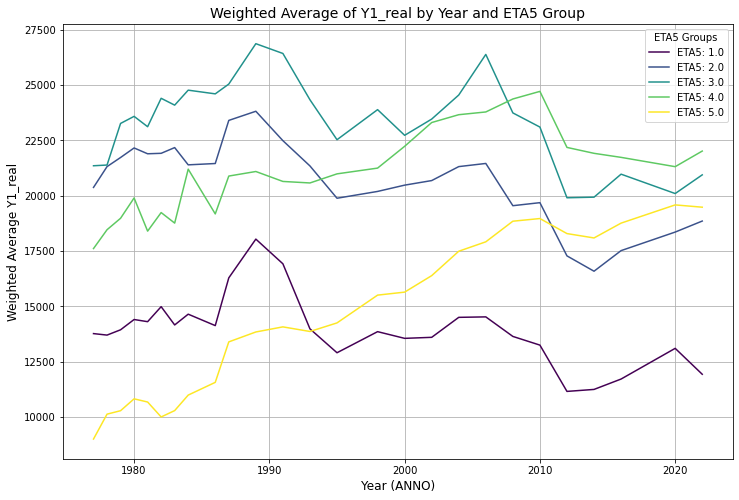

In [134]:
agerange_df = ind_df.groupby(['ANNO', 'ETA5']).apply(
    lambda group: ((group['Y1_real'] * group['PESOPOP']).sum() / group['PESOPOP'].sum())
    ).reset_index(name='Weighted_Average_Y1_real')

eta5_groups = agerange_df['ETA5'].unique()
colors = cm.viridis(np.linspace(0, 1, len(eta5_groups)))

plt.figure(figsize=(12, 8))
for i, eta5 in enumerate(eta5_groups):
    subset = agerange_df[agerange_df['ETA5'] == eta5]
    plt.plot(subset['ANNO'], subset['Weighted_Average_Y1_real'], 
             label=f'ETA5: {eta5}', color=colors[i])

# Adding labels, title, and legend
plt.title('Weighted Average of Y1_real by Year and ETA5 Group', fontsize=14)
plt.xlabel('Year (ANNO)', fontsize=12)
plt.ylabel('Weighted Average Y1_real', fontsize=12)
plt.legend(title='ETA5 Groups', fontsize=10)
plt.grid(True)

# Displaying the plot
plt.show()

In [135]:
defl.rename(columns={'Anno': 'ANNO'}, inplace=True)

comp_fw = comp[comp["NORD"] == 1][["NQUEST", "NORD", "ANNO", "ETA", "ETA5"]].copy()
comp_fw = comp_fw.merge(weight[['NQUEST', 'ANNO', 'PESO', 'PESOPOP']], on=['NQUEST', 'ANNO'], how='left')
comp_fw = comp_fw.merge(defl[['ANNO', 'DEFL']], on=['ANNO'], how='inner')

fw_df = ricf.merge(comp_fw, on=['NQUEST', 'ANNO'], how='inner')
fw_df.fillna(0, inplace=True)
fw_df['A'] = fw_df['AR'] + fw_df['AF']
fw_df['W'] = fw_df['A'] - fw_df['PF']

fw_df['A_real'] = fw_df['A'] / fw_df['DEFL']
fw_df['W_real'] = fw_df['W'] / fw_df['DEFL']

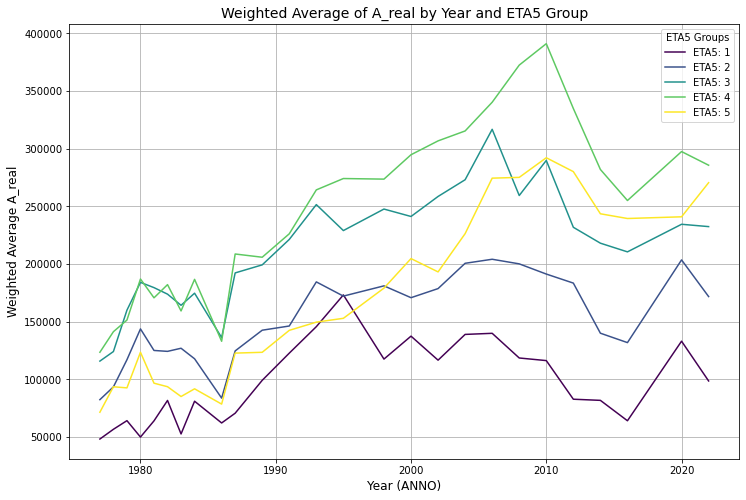

In [136]:
agerangew_df = fw_df.groupby(['ANNO', 'ETA5']).apply(
    lambda group: ((group['A_real'] * group['PESOPOP']).sum() / group['PESOPOP'].sum())
    ).reset_index(name='Weighted_A_real')

eta5_groups = agerangew_df['ETA5'].unique()
colors = cm.viridis(np.linspace(0, 1, len(eta5_groups)))

plt.figure(figsize=(12, 8))
for i, eta5 in enumerate(eta5_groups):
    subset = agerangew_df[agerangew_df['ETA5'] == eta5]
    plt.plot(subset['ANNO'], subset['Weighted_A_real'], 
             label=f'ETA5: {eta5}', color=colors[i])

# Adding labels, title, and legend
plt.title('Weighted Average of A_real by Year and ETA5 Group', fontsize=14)
plt.xlabel('Year (ANNO)', fontsize=12)
plt.ylabel('Weighted Average A_real', fontsize=12)
plt.legend(title='ETA5 Groups', fontsize=10)
plt.grid(True)

# Displaying the plot
plt.show()

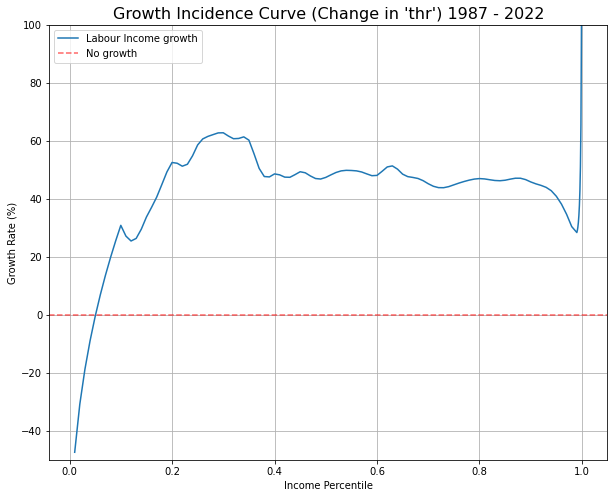

In [137]:
yearStart, yearEnd = 1987, 2022

# Generalized Pareto Interpolation distribution for YLabour
df_start = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoAged/Labor65, Italy, 1987.csv')
df_end = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoAged/Labor65, Italy, 2022.csv')

df_start = df_start[['p', 'thr', 'bracketavg']]
df_end = df_end[['p', 'thr', 'bracketavg']]

df_start['thr'] = df_start['thr'] / defl.query(f'ANNO == {yearStart}')['DEFL'].values
df_end['thr'] = df_end['thr'] / defl.query(f'ANNO == {yearEnd}')['DEFL'].values
df_start['bracketavg'] = df_start['bracketavg'] / defl.query(f'ANNO == {yearStart}')['DEFL'].values
df_end['bracketavg'] = df_end['bracketavg'] / defl.query(f'ANNO == {yearEnd}')['DEFL'].values

df_start.sort_values(by='p', inplace=True)
df_end.sort_values(by='p', inplace=True)

growth_old_df = pd.merge(df_start, df_end, on='p', how='inner')
growth_old_df['thr_diff'] = ((growth_old_df['thr_y'] - growth_old_df['thr_x']) / growth_old_df['thr_x']) * 100
growth_old_df['bracketavg_diff'] = ((growth_old_df['bracketavg_y'] - growth_old_df['bracketavg_x']) / growth_old_df['bracketavg_x']) * 100
growth_old_df.columns = ['Percentile', 'thr_start', 'bracketavg_start', 'thr_end', 'bracketavg_end', 'thr_growth', 'bracketavg_growth']



# Shiw data distribution
cols_tochange = [col for col in bracketavg_YL_df.columns if 'Q' in col]
datagrowth_df = pd.merge(bracketavg_YL_df, defl[['ANNO', 'DEFL']], left_on='ANNO', right_on='ANNO', how='inner')
datagrowth_df[cols_tochange] = datagrowth_df[cols_tochange].apply(lambda x: x / datagrowth_df['DEFL'], axis=0)
datagrowth_df = datagrowth_df.query(f'ANNO == {yearStart} | ANNO == {yearEnd}')
datagrowth_df = datagrowth_df.set_index('ANNO')[cols_tochange].T.reset_index()
datagrowth_df['diff'] = ((datagrowth_df[yearEnd] - datagrowth_df[yearStart]) / datagrowth_df[yearStart]) * 100
datagrowth_df['index'] = quantiles

# Plot the Growth Incidence Curve
plt.figure(figsize=[10, 8])
plt.plot(growth_old_df['Percentile'], growth_old_df['thr_growth'], label='Labour Income growth')
#plt.plot(datagrowth_df['index'], datagrowth_df['diff'], label='Shiw growth')

plt.axhline(y=0, color='red', alpha=0.6, linestyle='--', label='No growth')
plt.title(f"Growth Incidence Curve (Change in 'thr') {yearStart} - {yearEnd}", fontsize=16)
plt.ylabel("Growth Rate (%)")
plt.xlabel("Income Percentile")
plt.ylim(-50, 100)
plt.legend()
plt.grid(True)
plt.show()


In [138]:
# Define custom age bins and labels
age_bins = [0, 15, 65, 100]  # 15-24, 25-35, 40-65, 65+
age_labels = ['0-14', '15-64', '65+']

# Categorize ages
fw_df['Age_Group'] = pd.cut(fw_df['ETA'], bins=age_bins, labels=age_labels, right=False)

results = []
fw_df_aged = fw_df.query('Age_Group == "65+"')

for year, group in fw_df_aged.groupby('ANNO'):
    wealth = group['A'].values
    weights = group['PESOPOP'].values

    # Compute popsize and average
    popsize = np.sum(weights)
    average = np.average(wealth, weights=weights)

    # Compute thresholds and bracket averages
    thresholds, bracket_averages = weighted_quantile(wealth, quantiles, weights)

    # Append results for each quantile
    year_data = []
    for p, thr, bracketavg in zip(quantiles, thresholds, bracket_averages):
        year_data.append({
            'year': year,
            'country': 'Italy',
            'component': 'Wealth',
            'popsize': popsize,
            'average': average,
            'p': p,
            'thr': thr,
            'bracketavg': bracketavg
        })

    year_df = pd.DataFrame(year_data)
    year_df.to_csv(f"{year}_data.csv", index=False, sep=',')

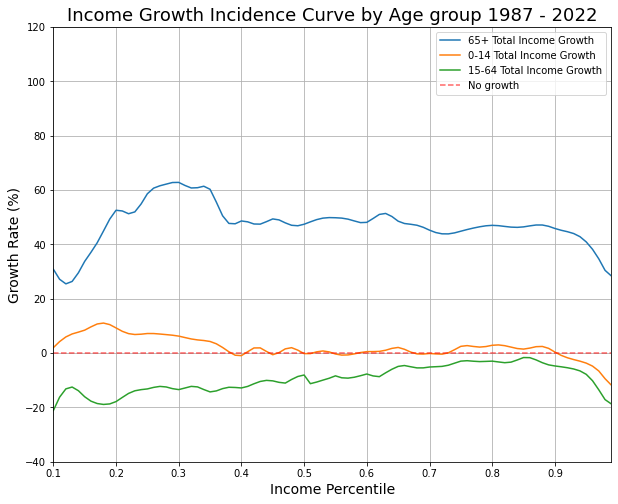

In [139]:
# Define parameters
yearStart, yearEnd = 1987, 2022
file_labels = ["Labor65", "Labor15", "LaborWork"]
legend_labels = ["65+ Total Income Growth", "0-14 Total Income Growth", "15-64 Total Income Growth"]

growth_data = {}  # Dictionary to store growth data for table

plt.figure(figsize=[10, 8])  # Create a single figure

# Loop through each dataset
for label, legend_label in zip(file_labels, legend_labels):
    # Load CSV files
    df_start = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoAged/{label}, Italy, {yearStart}.csv')
    df_end = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoAged/{label}, Italy, {yearEnd}.csv')

    # Keep necessary columns
    df_start = df_start[['p', 'thr', 'bracketavg']]
    df_end = df_end[['p', 'thr', 'bracketavg']]

    # Apply deflation
    defl_start = defl.query(f'ANNO == {yearStart}')['DEFL'].values[0]
    defl_end = defl.query(f'ANNO == {yearEnd}')['DEFL'].values[0]

    df_start['thr'] /= defl_start
    df_end['thr'] /= defl_end
    df_start['bracketavg'] /= defl_start
    df_end['bracketavg'] /= defl_end

    # Sort by percentile
    df_start.sort_values(by='p', inplace=True)
    df_end.sort_values(by='p', inplace=True)

    # Calculate growth
    growth_df = pd.merge(df_start, df_end, on='p', how='inner', suffixes=('_start', '_end'))
    growth_df['thr_growth'] = ((growth_df['thr_end'] - growth_df['thr_start']) / growth_df['thr_start']) * 100

    # Store data for table
    growth_data[legend_label] = growth_df['thr_growth'].values

    # Plot each dataset with the correct label
    plt.plot(growth_df['p'], growth_df['thr_growth'], label=legend_label)

# Add horizontal line for zero growth
plt.axhline(y=0, color='red', alpha=0.6, linestyle='--', label='No growth')

# Customize plot
plt.title(f"Income Growth Incidence Curve by Age group {yearStart} - {yearEnd}", fontsize=18)
plt.ylabel("Growth Rate (%)", fontsize=14)
plt.xlabel("Income Percentile", fontsize=14)
plt.ylim(-40, 120)
plt.xlim(0.1, 0.99)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Create a DataFrame with growth data
percentiles = growth_df['p'].values

table_df = pd.DataFrame(growth_data, index=percentiles)
table_df.index.name = "Income Percentile"


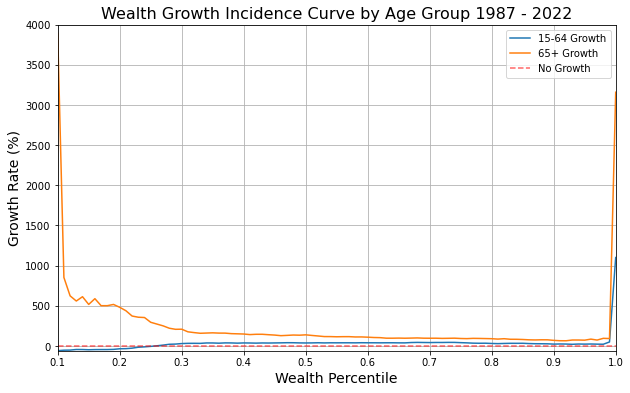

In [140]:
# Define quantiles of interest and age bins
quantiles = np.linspace(0.01, 1, 100)  
age_bins = [15, 65, 100]
age_labels = ['15-64', '65+']

# Categorize ages
fw_df['Age_Group'] = pd.cut(fw_df['ETA'], bins=age_bins, labels=age_labels, right=False)

# Initialize dictionary to store results for each age group
age_group_thresholds = {}

# Loop over age groups
for age_group in age_labels:
    thresholds_dict = {}

    # Filter data for the age group
    fw_df_age = fw_df.query(f'Age_Group == "{age_group}"')

    for year, group in fw_df_age.groupby('ANNO'):
        wealth = group['A'].values
        weights = group['PESOPOP'].values

        # Compute thresholds
        thresholds, _ = weighted_quantile(wealth, quantiles, weights)

        # Store thresholds in the dictionary
        thresholds_dict[year] = thresholds

    # Convert dictionary to DataFrame (percentiles as rows, years as columns)
    thresholds_df = pd.DataFrame(thresholds_dict, index=quantiles)
    thresholds_df.index.name = "Percentile"

    # Deflate values
    defl_start = defl.query(f'ANNO == 1987')['DEFL'].values[0]
    defl_end = defl.query(f'ANNO == 2022')['DEFL'].values[0]

    thresholds_df = thresholds_df[[1987, 2022]]
    thresholds_df[2022] /= defl_end
    thresholds_df[1987] /= defl_start

    # Compute growth rate
    thresholds_df['Growth (%)'] = (thresholds_df[2022] - thresholds_df[1987]) / thresholds_df[1987] * 100

    # Store results
    age_group_thresholds[age_group] = thresholds_df

# Plot Growth Curves
plt.figure(figsize=(10, 6))

for age_group, df in age_group_thresholds.items():
    plt.plot(df.index, df['Growth (%)'], label=f"{age_group} Growth")

# Add reference line
plt.axhline(y=0, color='red', linestyle='--', alpha=0.6, label="No Growth")

# Customize plot
plt.title("Wealth Growth Incidence Curve by Age Group 1987 - 2022", fontsize=16)
plt.xlabel("Wealth Percentile", fontsize=14)
plt.ylabel("Growth Rate (%)", fontsize=14)
plt.ylim(-60, 4000)
plt.xlim(0.1, 1)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [141]:
age_group_thresholds['65+'].tail(50)

,1987,2022,Growth (%)
Percentile,,,
0.51,6.612629e+04,1.529056e+05,131.232766
0.52,6.953544e+04,1.560333e+05,124.393887
0.53,7.369914e+04,1.600175e+05,117.122661
0.54,7.514727e+04,1.628623e+05,116.724156
0.55,7.802423e+04,1.673996e+05,114.548278
0.56,8.028624e+04,1.733523e+05,115.917857
0.57,8.248478e+04,1.782418e+05,116.090466
0.58,8.530394e+04,1.810632e+05,112.256547
0.59,8.655448e+04,1.840202e+05,112.606179


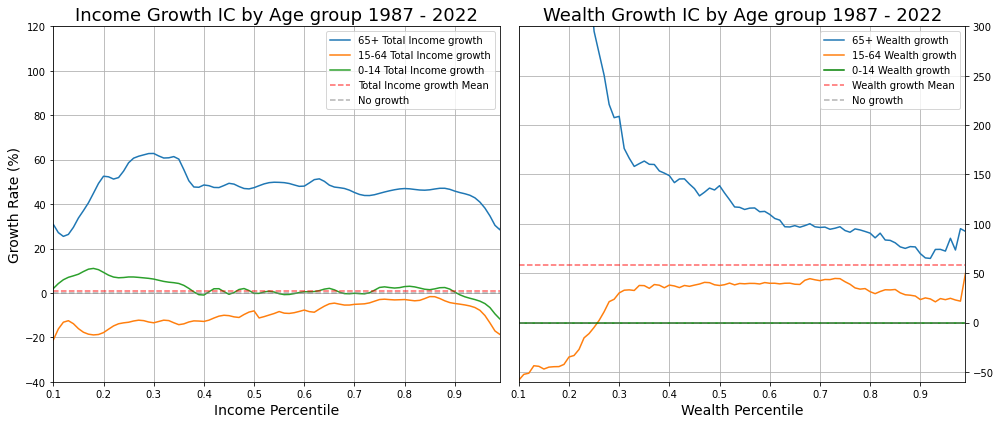

In [142]:
# Define parameters
yearStart, yearEnd = 1987, 2022
file_labels = ["Labor65", "LaborWork", "Labor15"]
legend_labels = ["65+ Total Income growth", "15-64 Total Income growth", "0-14 Total Income growth"]

growth_data = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Two plots in one row

# Left plot: Income Growth Incidence Curve
for label, legend_label in zip(file_labels, legend_labels):
    df_start = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoAged/{label}, Italy, {yearStart}.csv')
    df_end = pd.read_csv(f'/Users/gabrielvincenzi/Desktop/Economics/Thesis/ParetoAged/{label}, Italy, {yearEnd}.csv')

    df_start = df_start[['p', 'thr', 'bracketavg']]
    df_end = df_end[['p', 'thr', 'bracketavg']]

    defl_start = defl.query(f'ANNO == {yearStart}')['DEFL'].values[0]
    defl_end = defl.query(f'ANNO == {yearEnd}')['DEFL'].values[0]

    df_start['thr'] /= defl_start
    df_end['thr'] /= defl_end

    df_start.sort_values(by='p', inplace=True)
    df_end.sort_values(by='p', inplace=True)

    growth_df = pd.merge(df_start, df_end, on='p', how='inner', suffixes=('_start', '_end'))
    growth_df['thr_growth'] = ((growth_df['thr_end'] - growth_df['thr_start']) / growth_df['thr_start']) * 100

    growth_data[legend_label] = growth_df['thr_growth'].values

    axes[0].plot(growth_df['p'], growth_df['thr_growth'], label=legend_label)

axes[0].axhline(y=mean_l, color='red', alpha=0.6, linestyle='--', label='Total Income growth Mean')
axes[0].axhline(y=0, color='grey', alpha=0.6, linestyle='--', label='No growth')
axes[0].set_title(f"Income Growth IC by Age group {yearStart} - {yearEnd}", fontsize=18)
axes[0].set_xlabel("Income Percentile", fontsize=14)
axes[0].set_ylabel("Growth Rate (%)", fontsize=14)
axes[0].set_ylim(-40, 120)
axes[0].set_xlim(0.1, 0.99)
axes[0].legend()
axes[0].grid(True)

# Right plot: Wealth Growth Incidence Curve
age_bins = [15, 65, 100]
age_labels = ['15-64', '65+']

fw_df['Age_Group'] = pd.cut(fw_df['ETA'], bins=age_bins, labels=age_labels, right=False)

age_group_thresholds = {}

for age_group in reversed(age_labels):
    thresholds_dict = {}
    fw_df_age = fw_df.query(f'Age_Group == "{age_group}"')

    for year, group in fw_df_age.groupby('ANNO'):
        wealth = group['A'].values
        weights = group['PESOPOP'].values

        thresholds, _ = weighted_quantile(wealth, np.linspace(0.01, 0.99, 99), weights)
        thresholds_dict[year] = thresholds

    thresholds_df = pd.DataFrame(thresholds_dict, index=np.linspace(0.01, 0.99, 99))
    thresholds_df.index.name = "Percentile"

    defl_start = defl.query(f'ANNO == 1987')['DEFL'].values[0]
    defl_end = defl.query(f'ANNO == 2022')['DEFL'].values[0]

    thresholds_df = thresholds_df[[1987, 2022]]
    thresholds_df[2022] /= defl_end
    thresholds_df[1987] /= defl_start

    thresholds_df['Growth (%)'] = (thresholds_df[2022] - thresholds_df[1987]) / thresholds_df[1987] * 100
    age_group_thresholds[age_group] = thresholds_df

for age_group, df in age_group_thresholds.items():
    axes[1].plot(df.index, df['Growth (%)'], label=f"{age_group} Wealth growth")

axes[1].axhline(y=0, color='green', alpha=1, label="0-14 Wealth growth")
axes[1].axhline(y=mean_w, color='red', alpha=0.6, linestyle='--', label='Wealth growth Mean')
axes[1].axhline(y=0, color='grey', linestyle='--', alpha=0.6, label="No growth")
axes[1].set_title("Wealth Growth IC by Age group 1987 - 2022", fontsize=18)
axes[1].set_xlabel("Wealth Percentile", fontsize=14)
#axes[1].set_ylabel("Growth Rate (%)", fontsize=14)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set_ylim(-60, 300)
axes[1].set_xlim(0.1, 0.99)
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [143]:
top_past = age_group_thresholds['65+'].iloc[98][1987]
top_pres = age_group_thresholds['65+'].iloc[98][2022]
bottom_past = age_group_thresholds['65+'].iloc[49][1987]
bottom_pres = age_group_thresholds['65+'].iloc[49][2022]

bottom_past_w = age_group_thresholds['15-64'].iloc[49][1987]

diff_past = top_past - bottom_past
diff_pres = top_pres - bottom_pres

(diff_pres - diff_past) / bottom_past

12.424735283158002

In [144]:
# Define the range of percentiles
percentiles = range(10, 109)  # From 10 to 108

# Initialize lists to store the computed values
ratio_diffs = []
x_values = []  # Stores corresponding percentiles from the dataframe

# Compute ratio_diff for each percentile
for bottom in percentiles:
    top = 108  # Fixed top percentile position (99.9th percentile)
    
    bottom_start = growth_df_Y1.iloc[bottom]['thr_start']
    bottom_end = growth_df_Y1.iloc[bottom]['thr_end']
    top_start = growth_df_Y1.iloc[top]['thr_start']
    top_end = growth_df_Y1.iloc[top]['thr_end']
    
    diff_start = top_start - bottom_start  # Difference rich to poor (initial)
    diff_end = top_end - bottom_end        # Difference rich to poor (final)
    diff = diff_end - diff_start           # Change in difference
    ratio_diff = diff / bottom_start       # Ratio of difference change to initial bottom wealth
    
    ratio_diffs.append(ratio_diff)
    x_values.append(growth_df_Y1.iloc[bottom]['Percentile'])  # Store actual percentile values

# Convert to DataFrame for plotting
df_ratio = pd.DataFrame({'Percentile': x_values, 'Ratio_Diff': ratio_diffs})
df_ratio

,Percentile,Ratio_Diff
0,0.100,4.898253
1,0.110,4.710804
2,0.120,4.533266
3,0.130,4.365869
4,0.140,4.208291
...,...,...
94,0.995,0.386146
95,0.996,0.344410
96,0.997,0.285762
97,0.998,0.192700


In [145]:
# Instead of using per capita wealth, put the threshold as line graph for each percentile. !!!

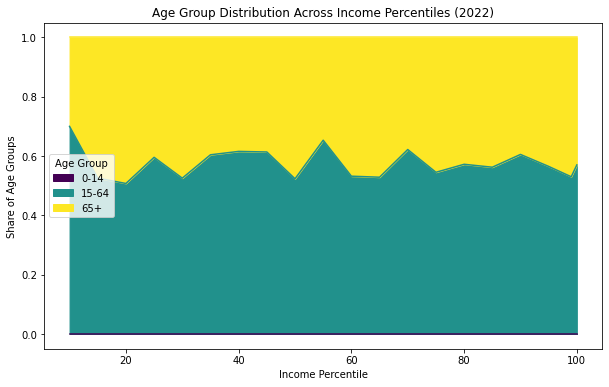

In [146]:
bins = [0, 14, 64, float('inf')]
labels = ['0-14', '15-64', '65+']

# Create age group column
ind_df['Age Group'] = pd.cut(ind_df['ETA'], bins=bins, labels=labels, right=True)
df_2022 = ind_df.query("ANNO == 2022")

# Aggregate data by Y1_perc and Age Group
df_grouped = df_2022.groupby(['Y1perc', 'Age Group']).size().unstack(fill_value=0)

# Convert to percentages of total in each percentile
df_percent = df_grouped.div(df_grouped.sum(axis=1), axis=0)

df_percent.plot(kind='area', stacked=True, colormap='viridis', figsize=(10, 6))

plt.xlabel('Income Percentile')
plt.ylabel('Share of Age Groups')
plt.title('Age Group Distribution Across Income Percentiles (2022)')
plt.legend(title='Age Group')
plt.show()

# Regional Statistics

## Regional and Municipality geodata

In [9]:
import plotly.express as px
import json

file_path = 'Redditi-Comuni/limits_IT_municipalities.geojson'

with open(file_path, 'r') as file:
    municipalities = json.load(file)

In [10]:
#fig = px.choropleth_mapbox(municipality_snai, geojson=municipalities, 
#                           locations='Codice catastale',
#                           featureidkey='properties.com_catasto_code',
#                           color='mean_income',
#                           color_continuous_scale="Blackbody",
#                           range_color= (0, 80000),
#                           mapbox_style="carto-positron",
#                           zoom=5, center = {"lat": 42.69004, "lon": 12.56964},
#                           opacity=0.5,
#                           labels={'mean_income':'income per capita'}
#                          )
#fig = fig.update_traces(
#    marker_line_width=0
#)
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

In [11]:
year = 2019
municipality = pd.read_csv(f'Redditi-Comuni/{year}.csv', sep=';', encoding='ISO-8859-1')
if year in [2019, 2020, 2021]:
        municipality.columns = municipality.columns[1:].tolist() + ["Extra_Column"]
        municipality.reset_index(inplace=True)  # Preserve the old index as a column
        municipality.rename(columns={'index': 'Anno'}, inplace=True)
                            
municipality = municipality.fillna(0).copy()
df_gini = municipality

In [12]:
df_gini[df_gini[[col for col in df_gini.columns if 'Frequenza' in col]].sum(axis=1) == df_gini[[col for col in df_gini.columns if 'Frequenza' in col]].sum(axis=1).min()]

,Anno,Codice catastale,Codice Istat Comune,Denominazione Comune,Sigla Provincia,Regione,Codice Istat Regione,Numero contribuenti,Reddito da fabbricati - Frequenza,Reddito da fabbricati - Ammontare in euro,...,Reddito complessivo da 26000 a 55000 euro - Frequenza,Reddito complessivo da 26000 a 55000 euro - Ammontare in euro,Reddito complessivo da 55000 a 75000 euro - Frequenza,Reddito complessivo da 55000 a 75000 euro - Ammontare in euro,Reddito complessivo da 75000 a 120000 euro - Frequenza,Reddito complessivo da 75000 a 120000 euro - Ammontare in euro,Reddito complessivo oltre 120000 euro - Frequenza,Reddito complessivo oltre 120000 euro - Ammontare in euro,,Extra_Column
4389,2019,F758,97055,MORTERONE,LC,Lombardia,3,26,15.0,7929.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
[col for col in df_gini.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col) and "minore" not in col]

['Reddito complessivo da 0 a 10000 euro - Frequenza',
 'Reddito complessivo da 0 a 10000 euro - Ammontare in euro',
 'Reddito complessivo da 10000 a 15000 euro - Frequenza',
 'Reddito complessivo da 10000 a 15000 euro - Ammontare in euro',
 'Reddito complessivo da 15000 a 26000 euro - Frequenza',
 'Reddito complessivo da 15000 a 26000 euro - Ammontare in euro',
 'Reddito complessivo da 26000 a 55000 euro - Frequenza',
 'Reddito complessivo da 26000 a 55000 euro - Ammontare in euro',
 'Reddito complessivo da 55000 a 75000 euro - Frequenza',
 'Reddito complessivo da 55000 a 75000 euro - Ammontare in euro',
 'Reddito complessivo da 75000 a 120000 euro - Frequenza',
 'Reddito complessivo da 75000 a 120000 euro - Ammontare in euro',
 'Reddito complessivo oltre 120000 euro - Frequenza',
 'Reddito complessivo oltre 120000 euro - Ammontare in euro']

In [14]:
columns_freq = [col for col in municipality.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col) and "minore" not in col]
gini_indexes = []

for munic in range(len(df_gini)):
    df_temp = pd.DataFrame(columns=['pop', 'income'])
    #print(munic)

    for i in range(0, len(columns_freq), 2):
        freq_col = columns_freq[i]
        amount_col = columns_freq[i + 1]

        #print(freq_col, amount_col)

        new_row = pd.DataFrame([[df_gini.loc[munic, freq_col], df_gini.loc[munic, amount_col]]], columns=['pop', 'income'])
        df_temp = pd.concat([df_temp, new_row], ignore_index=True)

    df_temp['cum_pop'] = df_temp['pop'].cumsum()
    df_temp['cum_income'] = df_temp['income'].cumsum()

    total_population = df_temp['pop'].sum()
    total_wealth = df_temp['income'].sum()

    if total_population > 0:
        df_temp['cum_pop%'] = df_temp['cum_pop'] / total_population
        df_temp['cum_income%'] = df_temp['cum_income'] / total_wealth

        gini_index = 1 - np.sum((df_temp['cum_pop%'][1:].values - df_temp['cum_pop%'][:-1].values) *
                                (df_temp['cum_income%'][1:].values + df_temp['cum_income%'][:-1].values))
    else:
        gini_index = None

    gini_indexes.append(gini_index)

len(df_gini) == len(gini_indexes)

True

In [15]:
df_gini['gini_index'] = gini_indexes
df_gini.to_csv('gini_dataframe.csv', index=False)

In [16]:
municipality_df = pd.read_csv('gini_dataframe.csv')

## Regional Income Statistics

In [17]:
# Extract income range labels (remove " - Frequenza")
#income_ranges = [col.replace(" - Frequenza", "") for col in municipality.columns if "complessivo" in col and "Frequenza" in col]
# Create a mapping of income ranges to numbers (1, 2, 3, ...)
#income_mapping = {name: i+1 for i, name in enumerate(income_ranges)}
# Melt DataFrame to long format
#municipality_df = municipality.melt(id_vars=["municipality", "region"], 
#                                       var_name="income_range", 
#                                       value_name="frequency").copy()
# Map income_range to numeric encoding
#municipality_df["income_range"] = municipality_df["income_range"].str.replace(" - Frequenza", "", regex=False)
#municipality_df["income_range"] = municipality_df["income_range"].map(income_mapping)
#municipality_data = pd.get_dummies(municipality_df, columns=['region'], drop_first=True)
#model = OrderedModel(
#    endog=municipality_data['income_range'],
#    exog=municipality_data[[col for col in municipality_data.columns if "region" in col]],
#    weights=municipality_data['frequency']
#)
#results = model.fit(method='bfgs')

In [18]:
municipality_df['retired_share'] = municipality['Reddito da pensione - Frequenza'] / municipality['Numero contribuenti']

columns_freq = [col for col in municipality_df.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col) and "minore" not in col]
columns_to_keep = ["Denominazione Comune", "Regione", "Codice Istat Comune", "Codice catastale", "gini_index", "retired_share"] + columns_freq
municipality_df = municipality_df[columns_to_keep].copy()
municipality_df.rename(columns={'Denominazione Comune': 'municipality', 'Regione': 'region'}, inplace=True)
municipality_df.fillna(0, inplace=True)

municipality_df['pop_sum'] = municipality_df[[col for col in municipality_df.columns if "Frequenza" in col]].sum(axis=1)
municipality_df['income_sum'] = municipality_df[[col for col in municipality_df.columns if "Ammontare" in col]].sum(axis=1)
municipality_df['mean_income'] = municipality_df['income_sum'] / municipality_df['pop_sum']

municipality_df.drop(columns=columns_freq, inplace=True)
municipality_data = pd.get_dummies(municipality_df, columns=['region'], drop_first=False)

In [19]:
municipality_df

,municipality,region,Codice Istat Comune,Codice catastale,gini_index,retired_share,pop_sum,income_sum,mean_income
0,ABANO TERME,Veneto,28001,A001,0.443201,0.358767,14646.0,363442968.0,24815.169193
1,ABBADIA CERRETO,Lombardia,98001,A004,0.288514,0.370732,190.0,3594762.0,18919.800000
2,ABBADIA LARIANA,Lombardia,97001,A005,0.407160,0.343712,2394.0,61163872.0,25548.818713
3,ABBADIA SAN SALVATORE,Toscana,52001,A006,0.374780,0.399713,4815.0,88542693.0,18388.928972
4,ABBASANTA,Sardegna,95001,A007,0.404722,0.372617,1682.0,31398619.0,18667.431034
...,...,...,...,...,...,...,...,...,...
7899,PRESICCE-ACQUARICA,Puglia,75098,M428,0.571601,0.418303,6150.0,75780851.0,12322.089593
7900,BORGO D'ANAUNIA,Trentino Alto Adige(P.A.Trento),22252,M429,0.435361,0.354559,2041.0,41499495.0,20332.922587
7901,NOVELLA,Trentino Alto Adige(P.A.Trento),22253,M430,0.536993,0.296383,3768.0,58772791.0,15597.874469
7902,VILLE DI FIEMME,Trentino Alto Adige(P.A.Trento),22254,M431,0.415511,0.308470,2045.0,47189026.0,23075.318337


In [20]:
y = municipality_data['mean_income']
x = municipality_data.drop(columns=['municipality', 'income_sum', 'mean_income', 'pop_sum', 
                                    'Codice Istat Comune', 'region_Mancante/errata',
                                    'Codice catastale', 'retired_share']) # 
X = sm.add_constant(x)

model1 = sm.OLS(y, x).fit(cov_type='HC1')
print(model1.summary())

                                 OLS Regression Results                                
Dep. Variable:            mean_income   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          2.177e+04
Date:                Sat, 29 Mar 2025   Prob (F-statistic):                        0.00
Time:                        18:03:35   Log-Likelihood:                         -74093.
No. Observations:                7904   AIC:                                  1.482e+05
Df Residuals:                    7882   BIC:                                  1.484e+05
Df Model:                          22                                                  
Covariance Type:                  HC1                                                  
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------

In [21]:
snaicodes = pd.read_excel('Redditi-Comuni/snai-codes.xlsx', header=1)

snaicodes = snaicodes.rename(columns={'Codice Comune\n(Istat)\n': 'Codice Istat Comune', 'Macroclasse comune ': 'Macroclasse'})
snaicodes = snaicodes[['Codice Istat Comune', 'Classe comune', 'Macroclasse']].copy()

municipality_snai = pd.merge(municipality_df, snaicodes, on='Codice Istat Comune', how='inner')

municipality.shape, snaicodes.shape, municipality_snai.shape

((7904, 53), (7903, 3), (7903, 11))

In [22]:
municipality_df

,municipality,region,Codice Istat Comune,Codice catastale,gini_index,retired_share,pop_sum,income_sum,mean_income
0,ABANO TERME,Veneto,28001,A001,0.443201,0.358767,14646.0,363442968.0,24815.169193
1,ABBADIA CERRETO,Lombardia,98001,A004,0.288514,0.370732,190.0,3594762.0,18919.800000
2,ABBADIA LARIANA,Lombardia,97001,A005,0.407160,0.343712,2394.0,61163872.0,25548.818713
3,ABBADIA SAN SALVATORE,Toscana,52001,A006,0.374780,0.399713,4815.0,88542693.0,18388.928972
4,ABBASANTA,Sardegna,95001,A007,0.404722,0.372617,1682.0,31398619.0,18667.431034
...,...,...,...,...,...,...,...,...,...
7899,PRESICCE-ACQUARICA,Puglia,75098,M428,0.571601,0.418303,6150.0,75780851.0,12322.089593
7900,BORGO D'ANAUNIA,Trentino Alto Adige(P.A.Trento),22252,M429,0.435361,0.354559,2041.0,41499495.0,20332.922587
7901,NOVELLA,Trentino Alto Adige(P.A.Trento),22253,M430,0.536993,0.296383,3768.0,58772791.0,15597.874469
7902,VILLE DI FIEMME,Trentino Alto Adige(P.A.Trento),22254,M431,0.415511,0.308470,2045.0,47189026.0,23075.318337


In [23]:
municipality_snai_data = pd.get_dummies(municipality_snai, columns=['Classe comune'], drop_first=False)

y = municipality_snai_data['mean_income']
x = municipality_snai_data[[col for col in municipality_snai_data.columns if 'Classe' in col] + ['gini_index']]
X = sm.add_constant(x)

model2 = sm.OLS(y, x).fit(cov_type='HC1')
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_income   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 29 Mar 2025   Prob (F-statistic):                nan
Time:                        18:03:51   Log-Likelihood:                -75361.
No. Observations:                7903   AIC:                         1.507e+05
Df Residuals:                    7896   BIC:                         1.508e+05
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [24]:
print(model1.params.apply(lambda x: f"{x:.4f}"))
print(model2.params.apply(lambda x: f"{x:.4f}"))

gini_index                                  3121.3989
region_Abruzzo                             14382.9246
region_Basilicata                          13187.7735
region_Calabria                            11858.1432
region_Campania                            13729.2059
region_Emilia Romagna                      20621.9051
region_Friuli Venezia Giulia               19257.6511
region_Lazio                               16396.6315
region_Liguria                             18373.2802
region_Lombardia                           20759.1978
region_Marche                              17135.1557
region_Molise                              12292.3976
region_Piemonte                            19214.5445
region_Puglia                              13675.7908
region_Sardegna                            13609.3994
region_Sicilia                             13047.9434
region_Toscana                             19120.7471
region_Trentino Alto Adige(P.A.Bolzano)    21983.1363
region_Trentino Alto Adige(P

In [25]:
municipality_snai_data = pd.get_dummies(municipality_snai, columns=['Classe comune'], drop_first=True)
municipality_snai_data_df = pd.get_dummies(municipality_snai_data, columns=['region'], drop_first=True)

y = municipality_snai_data_df['mean_income']
x = municipality_snai_data_df[[col for col in municipality_snai_data_df.columns if 'Classe' in col or 'region' in col] + ['gini_index', 'retired_share']]
X = sm.add_constant(x)

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_income   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     842.1
Date:                Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:03:53   Log-Likelihood:                -72777.
No. Observations:                7903   AIC:                         1.456e+05
Df Residuals:                    7875   BIC:                         1.458e+05
Df Model:                          27                                         
Covariance Type:                  HC1                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [26]:
print(model.params.apply(lambda x: f"{x:.4f}"))

const                                       24658.9946
Classe comune_B - Polo intercomunale        -1372.6474
Classe comune_C - Cintura                   -2336.0445
Classe comune_D - Intermedio                -3727.9375
Classe comune_E - Periferico                -4306.7354
Classe comune_F - Ultraperiferico           -4192.8255
region_Basilicata                            -889.1234
region_Calabria                             -2513.0517
region_Campania                             -1937.6914
region_Emilia Romagna                        4729.9504
region_Friuli Venezia Giulia                 3759.3680
region_Lazio                                 1167.3413
region_Liguria                               3263.4662
region_Lombardia                             4588.7186
region_Marche                                1517.9974
region_Molise                               -1247.4025
region_Piemonte                              3822.0228
region_Puglia                               -1922.4877
region_Sar

In [27]:
municipality_agg = municipality_snai.groupby('Classe comune')[['pop_sum', 'income_sum']].sum().reset_index()
municipality_agg['mean_income'] = municipality_agg['income_sum'] / municipality_agg['pop_sum']
municipality_agg

,Classe comune,pop_sum,income_sum,mean_income
0,A - Polo,14642087.0,3.625483e+11,24760.699360
1,B - Polo intercomunale,1961763.0,4.073062e+10,20762.253221
2,C - Cintura,15272557.0,3.257502e+11,21329.119102
3,D - Intermedio,5779419.0,1.063787e+11,18406.466866
4,E - Periferico,2463781.0,4.102471e+10,16651.120074
5,F - Ultraperiferico,442187.0,7.009169e+09,15851.141302


In [28]:
years = np.linspace(2000, 2022, 23).astype(int)
municipality_historical = pd.DataFrame(columns=['Classe comune', 'pop_sum', 'income_sum', 'mean_income', 'year'])

snaicodes = pd.read_excel('Redditi-Comuni/snai-codes.xlsx', header=1)
snaicodes = snaicodes.rename(columns={'Codice Comune\n(Istat)\n': 'Codice Istat Comune', 'Macroclasse comune ': 'Macroclasse'})
snaicodes = snaicodes[['Codice Istat Comune', 'Classe comune', 'Macroclasse']].copy()

for year in years:
    #print(year)
    municipality = pd.read_csv(f'Redditi-Comuni/{year}.csv', sep=';', encoding='ISO-8859-1', header=0)
    deflator = defl.query(f'Anno == {year}')['DEFL'].iloc[0]
    
    if year in [2019, 2020, 2021]:
        municipality.columns = municipality.columns[1:].tolist() + ["Extra_Column"]

    municipality = municipality.fillna(0).copy()
    municipality_df = pd.concat([municipality.iloc[:, :8], municipality.iloc[:, -15:-1]], axis=1)

    if year in [2008, 2009, 2010, 2011]:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat'].astype(int)
    else:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat Comune'].astype(int)

    municipality_df['pop_sum'] = municipality_df[[col for col in municipality_df.columns if "Frequenza" in col]].sum(axis=1)
    municipality_df['income_sum'] = municipality_df[[col for col in municipality_df.columns if "Ammontare" in col]].sum(axis=1)

    columns_freq = [col for col in municipality_df.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col)]
    municipality_df.drop(columns=columns_freq, inplace=True)

    municipality_snai = pd.merge(municipality_df, snaicodes, on='Codice Istat Comune', how='inner')

    municipality_agg = municipality_snai.groupby('Classe comune')[['pop_sum', 'income_sum']].sum().reset_index()
    municipality_agg['mean_income'] = municipality_agg['income_sum'] / municipality_agg['pop_sum']
    municipality_agg['mean_income_real'] = municipality_agg['mean_income'] / deflator
    municipality_agg['pop_share'] = municipality_agg['pop_sum'] / municipality_agg['pop_sum'].sum(axis=0)
    municipality_agg['year'] = year

    municipality_historical = pd.concat([municipality_historical, municipality_agg], ignore_index=True)


In [29]:
municipality_historical.tail(20)

,Classe comune,pop_sum,income_sum,mean_income,year,mean_income_real,pop_share
118,E - Periferico,2568390.0,4.102471e+10,15972.929838,2019,15546.163456,0.053975
119,F - Ultraperiferico,444554.0,7.009169e+09,15766.742891,2019,15345.485433,0.009342
120,A - Polo,17261357.0,3.540483e+11,20511.034250,2020,19939.744301,0.366937
121,B - Polo intercomunale,2258212.0,3.974940e+10,17602.153882,2020,17111.884426,0.048004
122,C - Cintura,18251113.0,3.189944e+11,17478.081378,2020,16991.267690,0.387977
123,D - Intermedio,6308892.0,1.043071e+11,16533.344795,2020,16072.844677,0.134113
124,E - Periferico,2526526.0,4.011227e+10,15876.452968,2020,15434.249133,0.053708
125,F - Ultraperiferico,435628.0,6.806361e+09,15624.251529,2020,15189.072213,0.009260
126,A - Polo,17578656.0,3.721592e+11,21171.084567,2021,20256.791220,0.365891
127,B - Polo intercomunale,2302693.0,4.185020e+10,18174.457931,2021,17389.576745,0.047929


In [ ]:
percentiles = [0.25, 0.5, 0.99]
interp_percentiles = [0.2, 0.5, 0.9, 0.99]
years = np.linspace(2000, 2022, 23).astype(int)
municipality_historical = {}

snaicodes = pd.read_excel('Redditi-Comuni/snai-codes.xlsx', header=1)
snaicodes = snaicodes.rename(columns={'Codice Comune\n(Istat)\n': 'Codice Istat Comune', 'Macroclasse comune ': 'Macroclasse'})
snaicodes = snaicodes[['Codice Istat Comune', 'Classe comune', 'Macroclasse']].copy()

for year in years:
        print(year)

        if year not in municipality_historical:
                municipality_historical[year] = {}

        # Download the dataset for each Municipality and year
        municipality = pd.read_csv(f'Redditi-Comuni/{year}.csv', sep=';', encoding='ISO-8859-1', header=0)
        deflator = defl.query(f'Anno == {year}')['DEFL'].iloc[0]
        
        if year in [2019, 2020, 2021]:
                municipality.columns = municipality.columns[1:].tolist() + ["Extra_Column"]

        # Handle missing values and take only important columns for the analysis
        municipality = municipality.fillna(0).copy()
        municipality_df = pd.concat([municipality.iloc[:, :7], municipality.iloc[:, -15:]], axis=1)

        if year in [2008, 2009, 2010, 2011]:
                municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat'].astype(int)
        else:
                municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat Comune'].astype(int)
        
        # Merge with SNAI dataset
        municipality_snai = pd.merge(municipality_df, snaicodes, on='Codice Istat Comune', how='inner')

        # Group by each municipality class
        columns_freq = [col for col in municipality_df.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col) and "minore" not in col]
        municipality_agg = municipality_snai.groupby('Classe comune')[columns_freq].sum().reset_index()
        
        # Store DataFrames for each Classe comune
        grouped = municipality_agg.groupby('Classe comune')
        class_dfs = {}

        for name, group in grouped:
                # Melt the DataFrame to reshape it
                melted = pd.melt(group, id_vars=['Classe comune'], var_name='Income Range and Type', value_name='Value')

                # Split the 'Income Range and Type' column to separate the income range and type (Frequenza or Ammontare)
                melted[['Income Range', 'Type']] = melted['Income Range and Type'].str.extract(r'^(.*) - (.*)$')

                # Drop the original 'Income Range and Type' column as it is now split
                melted.drop(columns=['Income Range and Type'], inplace=True)

                # Pivot the table to get a structure with 'Classe comune', 'Income Range', and columns for 'Frequenza' and 'Ammontare'
                pivoted_df = melted.pivot_table(index=['Classe comune', 'Income Range'], columns='Type', values='Value', aggfunc='first')

                pivoted_df.rename(columns={'Ammontare in euro': 'income', 'Ammontare': 'income', 'Frequenza': 'freq'}, inplace=True)

                pivoted_df['mean_income'] = pivoted_df['income'] / pivoted_df['freq']
                pivoted_df['freq_cumul'] = pivoted_df['freq'].cumsum()
                pivoted_df['income_cumul'] = pivoted_df['income'].cumsum()

                # Reset the index to make it cleaner
                pivoted_df.reset_index(inplace=True)

                # Calculate the total population (sum of frequencies)
                total_population = pivoted_df['freq'].sum()
                average = pivoted_df['income'].sum() / pivoted_df['freq'].sum()

                # For each desired percentile
                class_percentiles = []
                for percentile in percentiles:
                        # Find the first row where cumulative frequency surpasses the percentile threshold
                        percentile_threshold = percentile * total_population
                        
                        # Get the row where cumulative frequency is greater than or equal to the threshold
                        percentile_row = pivoted_df[pivoted_df['freq_cumul'] >= percentile_threshold].iloc[0]

                        # Check if the range contains "oltre" (meaning "over")
                        income_range = percentile_row['Income Range']
                        if 'oltre' in income_range:
                                income_lower = int(re.findall(r'(\d+)(?=\s*euro)', income_range)[0])  # Extract the number after 'oltre'
                        else:
                                # Otherwise, extract the number after 'da'
                                income_lower = int(re.findall(r'(?<=da\s)(\d+)', income_range)[0])

                        # Store the result (percentile, income range, and the corresponding income)
                        class_percentiles.append({
                                'year': year,
                                'country': 'Italy',
                                'component': name,
                                'popsize': total_population,
                                'average': average,
                                'p': percentile,
                                'thr': income_lower,
                                'bracketavg': percentile_row['mean_income']
                        })

                # Interpolation
                df = pd.DataFrame(class_percentiles)
                interpolated_bracketavg = np.interp(interp_percentiles, df['p'], df['bracketavg'])

                estimated_thresholds = np.roll(interpolated_bracketavg, 1) +1 # Shift right
                estimated_thresholds[0] = 0

                # Create a new DataFrame with the interpolated values
                interpolated_df = pd.DataFrame({
                        'year': [year] * len(interp_percentiles),
                        'country': ['Italy'] * len(interp_percentiles),
                        'component': [name] * len(interp_percentiles),
                        'popsize': [total_population] * len(interp_percentiles),
                        'average': [average] * len(interp_percentiles),
                        'p': interp_percentiles,
                        'bracketavg': interpolated_bracketavg,
                        'thr': estimated_thresholds
                })

                # Store the percentiles for the current 'Classe comune'
                municipality_historical[year][name] = interpolated_df
                municipality_historical[year][name].to_csv(f'BaseDistribution/{year}-{name}-Income.csv')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [ ]:
municipality_historical[2001]['E - Periferico']

,year,country,component,popsize,average,p,bracketavg,thr
0,2001,Italy,E - Periferico,2347938.0,10959.404438,0.20,4796.358319,0.000000
1,2001,Italy,E - Periferico,2347938.0,10959.404438,0.50,4796.358319,4797.358319
2,2001,Italy,E - Periferico,2347938.0,10959.404438,0.90,28212.340667,4797.358319
3,2001,Italy,E - Periferico,2347938.0,10959.404438,0.99,33480.936695,28213.340667


In [ ]:
years = 2000, 2022
municipality_growth = {}

for name in municipality_historical[2000]:
    df_start = municipality_historical[years[0]][name]
    df_end = municipality_historical[years[-1]][name]

    df_growth = df_start.drop(columns=['bracketavg', 'year'])

    df_growth['growth'] = (df_end['bracketavg'] - df_start['bracketavg']) / df_start['bracketavg']

    municipality_growth[name] = df_growth

In [ ]:
def generate_fat_tail_incomes(start_value, frequency, total_income, alpha=2.5):
    """
    Generate a fat-tail income distribution starting from a given value using a Pareto distribution.
    Parameters:
    - start_value: The starting income value (e.g., 120000).
    - frequency: The number of individuals in this row.
    - total_income: The target total income for this row.
    - alpha: The shape parameter for the Pareto distribution (larger values lead to a steeper tail).
    
    Returns:
    - An array of incomes that increases rapidly in a fat-tailed manner.
    """
    # Generate Pareto-distributed income increments from the starting value
    pareto_incomes = np.random.pareto(alpha, frequency) * start_value
    
    # Scale the incomes so that their total equals the specified total_income
    scaling_factor = total_income / np.sum(pareto_incomes)
    pareto_incomes *= scaling_factor
    
    return pareto_incomes

In [ ]:
percentile = 0.99
years = np.linspace(2000, 2022, 23).astype(int)
municipality_historical = {}

for year in years:
    print(year)

    if year not in municipality_historical:
        municipality_historical[year] = {}

    # Load dataset
    municipality = pd.read_csv(f'Redditi-Comuni/{year}.csv', sep=';', encoding='ISO-8859-1', header=0)
    deflator = defl.query(f'Anno == {year}')['DEFL'].iloc[0]

    if year in [2019, 2020, 2021]:
        municipality.columns = municipality.columns[1:].tolist() + ["Extra_Column"]

    # Handle missing values and take only relevant columns
    municipality_df = municipality.fillna(0).copy()

    if year in [2008, 2009, 2010, 2011]:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat'].astype(int)
    else:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat Comune'].astype(int)

    # Merge with SNAI dataset
    municipality_snai = pd.merge(municipality_df, snaicodes, on='Codice Istat Comune', how='inner')

    # Group by each municipality class
    columns_freq = [col for col in municipality_df.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col) and "minore" not in col]
    municipality_agg = municipality_snai.groupby('Classe comune')[columns_freq].sum().reset_index()

    for col in municipality_agg.columns[1:]: 
        municipality_agg[col] = municipality_agg[col].clip(lower=0)

    # Store DataFrames for each Classe comune
    grouped = municipality_agg.groupby('Classe comune')
    class_dfs = {}

    national_income_array = []

    for name, group in grouped:
        # Melt the DataFrame to reshape it
        melted = pd.melt(group, id_vars=['Classe comune'], var_name='Income Range and Type', value_name='Value')

        # Split the 'Income Range and Type' column to separate the income range and type (Frequenza or Ammontare)
        melted[['Income Range', 'Type']] = melted['Income Range and Type'].str.extract(r'^(.*) - (.*)$')

        # Drop the original 'Income Range and Type' column as it is now split
        melted.drop(columns=['Income Range and Type'], inplace=True)

        # Pivot the table to get a structure with 'Classe comune', 'Income Range', and columns for 'Frequenza' and 'Ammontare'
        pivoted_df = melted.pivot_table(index=['Classe comune', 'Income Range'], columns='Type', values='Value', aggfunc='first')

        pivoted_df.rename(columns={'Ammontare in euro': 'income', 'Ammontare': 'income', 'Frequenza': 'freq'}, inplace=True)

        #print(pivoted_df.columns)
        #print(pivoted_df.head())

        # Compute mean income for each range
        pivoted_df = pivoted_df.reset_index()
        pivoted_df['freq'] = pivoted_df['freq'].fillna(0).astype(int)
        pivoted_df['mean_income'] = np.where(pivoted_df['freq'] != 0, pivoted_df['income'] / pivoted_df['freq'], 0)
        

        # Expand income distribution by creating an array of incomes based on frequencies
        income_array = np.concatenate([
            np.full(int(row['freq']) if idx != len(pivoted_df) - 1 else 0, row['mean_income'])  # Keep income for non-last rows
            for idx, (_, row) in enumerate(pivoted_df.iterrows())
        ])

        last_row_income_values = generate_fat_tail_incomes(120000, int(pivoted_df.iloc[-1]['freq']), pivoted_df.iloc[-1]['income'])
        income_array = np.concatenate([income_array, last_row_income_values])

        # Extend the national income array
        national_income_array.extend(income_array)

        # Compute total income and top 1% threshold
        income_array.sort()

        # Find the index corresponding to the top 1% cutoff
        cutoff_index = int(len(income_array) * percentile)

        # Sum income for the top 1% using the last (1%) portion of the sorted array
        top_1_percent_income = income_array[cutoff_index:].sum()

        # Compute the total income and top 1% share
        total_income = income_array.sum()
        top_1_percent_share = top_1_percent_income / total_income

        # Store results
        municipality_historical[year][name] = {
            'total_income': total_income,
            'top_1_percent_income': top_1_percent_income,
            'top_1_percent_share': top_1_percent_share,
            'income_array': income_array,
        }
    
    # Calculate national top 1%
    national_income_array.sort()
    national_top_1_percent_threshold = national_income_array[int(len(national_income_array) * percentile)]

    for name in municipality_historical[year]:
        class_data = municipality_historical[year][name]
        
        # Get the income array for the class
        income_array = class_data['income_array']
        total_freq = len(income_array)
        
        # Count the individuals above the national top 1% threshold
        individuals_above_top_1_percent = np.sum(income_array >= national_top_1_percent_threshold)
        
        # Store the count of individuals above the national top 1% threshold
        class_data['top_1_share'] = individuals_above_top_1_percent / total_freq


2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


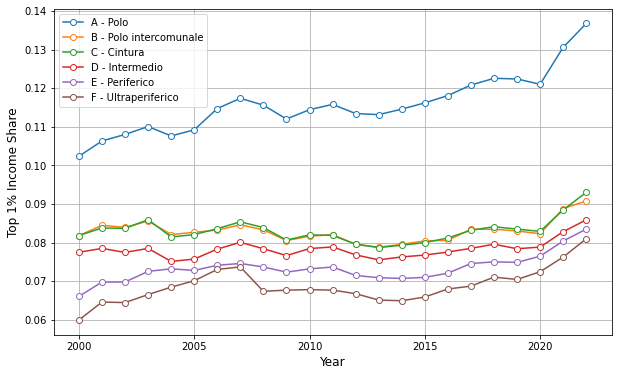

In [ ]:
# Prepare data for plotting
years = sorted(municipality_historical.keys())
top_1_shares = {name: [] for name in municipality_historical[years[0]].keys()}

for year in years:
    for name in top_1_shares.keys():
        top_1_shares[name].append(municipality_historical[year][name]['top_1_percent_share'])

# Plot the top 1% share over time for each municipality class
plt.figure(figsize=(10, 6))
for name, shares in top_1_shares.items():
    plt.plot(years, shares, marker='o', markerfacecolor='white', label=name)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Top 1% Income Share", fontsize=12)
#plt.title("Top 1% Income share over time by Municipality class", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
municipality_historical[2000]['A - Polo'], municipality_historical[2001]['A - Polo']

({'total_income': 243507164283.00287,
  'top_1_percent_income': 24958554683.176125,
  'top_1_percent_share': 0.10249618222390126,
  'income_array': array([5.68264567e-01, 2.66560167e+00, 3.17227592e+00, ...,
         1.87207407e+07, 2.13954724e+07, 6.06902090e+07]),
  'top_1_share': 0.031472243339799276},
 {'total_income': 257888540431.0023,
  'top_1_percent_income': 27426235399.484154,
  'top_1_percent_share': 0.10634918230041325,
  'income_array': array([4.63095855e-01, 2.11215889e+00, 2.75612312e+00, ...,
         2.19154089e+07, 2.25219539e+07, 2.67732603e+07]),
  'top_1_share': 0.016042027625503857})

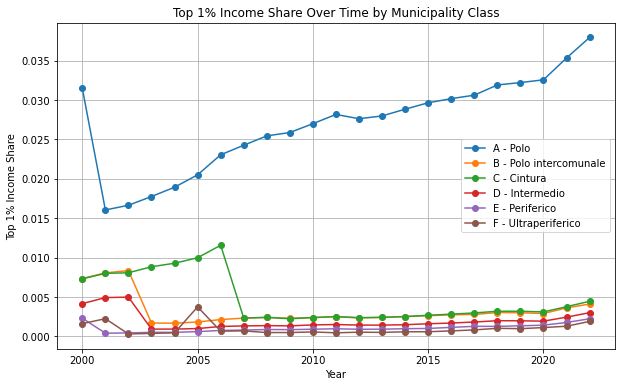

In [ ]:
# Prepare data for plotting
years = sorted(municipality_historical.keys())
top_1_nat_shares = {name: [] for name in municipality_historical[years[0]].keys()}

for year in years:
    for name in top_1_nat_shares.keys():
        top_1_nat_shares[name].append(municipality_historical[year][name]['top_1_share'])

# Plot the top 1% share over time for each municipality class
plt.figure(figsize=(10, 6))
for name, shares in top_1_nat_shares.items():
    plt.plot(years, shares, marker='o', label=name)

plt.xlabel("Year")
plt.ylabel("Top 1% Income Share")
plt.title("Top 1% Income Share Over Time by Municipality Class")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
year = 2021
print(year)

# Download the dataset for each Municipality and year
municipality = pd.read_csv(f'Redditi-Comuni/{year}.csv', sep=';', encoding='ISO-8859-1', header=0)
deflator = defl.query(f'Anno == {year}')['DEFL'].iloc[0]

if year in [2019, 2020, 2021]:
        municipality.columns = municipality.columns[1:].tolist() + ["Extra_Column"]

# Handle missing values and take only important columns for the analysis
municipality = municipality.fillna(0).copy()
municipality_df = pd.concat([municipality.iloc[:, :7], municipality.iloc[:, -15:]], axis=1)

if year in [2008, 2009, 2010, 2011]:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat'].astype(int)
        municipality_df.drop(columns=['Codice Istat'], inplace=True)
else:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat Comune'].astype(int)

# Merge with SNAI dataset
municipality_snai = pd.merge(municipality_df, snaicodes, on='Codice Istat Comune', how='inner')

# Group by each municipality class
columns_freq = [col for col in municipality_df.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col) and "minore" not in col]
municipality_agg = municipality_snai.groupby('Classe comune')[columns_freq].sum().reset_index()

for col in municipality_agg.columns[1:]: 
        municipality_agg[col] = municipality_agg[col].clip(lower=0)

# Store DataFrames for each Classe comune
grouped = municipality_agg.groupby('Classe comune')

class_dfs = {}

for name, group in grouped:
        # Melt the DataFrame to reshape it
        melted = pd.melt(group, id_vars=['Classe comune'], var_name='Income Range and Type', value_name='Value')

        # Split the 'Income Range and Type' column to separate the income range and type (Frequenza or Ammontare)
        melted[['Income Range', 'Type']] = melted['Income Range and Type'].str.extract(r'^(.*) - (.*)$')

        # Drop the original 'Income Range and Type' column as it is now split
        melted.drop(columns=['Income Range and Type'], inplace=True)

        # Pivot the table to get a structure with 'Classe comune', 'Income Range', and columns for 'Frequenza' and 'Ammontare'
        pivoted_df = melted.pivot_table(index=['Classe comune', 'Income Range'], columns='Type', values='Value', aggfunc='first')

        pivoted_df.rename(columns={'Ammontare in euro': 'income', 'Ammontare': 'income', 'Frequenza': 'freq'}, inplace=True)

        # Compute mean income for each range
        pivoted_df['freq'] = pivoted_df['freq'].fillna(0).astype(int)
        pivoted_df['mean_income'] = np.where(pivoted_df['freq'] != 0, pivoted_df['income'] / pivoted_df['freq'], 0)


        # Expand income distribution by creating an array of incomes based on frequencies
        income_array = np.concatenate([
                np.full(int(row['freq']), row['mean_income']) for _, row in pivoted_df.iterrows()
        ])

        income_array = np.concatenate([income_array, np.zeros(int(0.1 * len(income_array)))])

        # Compute total income and top 1% threshold
        income_array.sort()

        # Find the index corresponding to the top 1% cutoff
        cutoff_index = int(len(income_array) * 0.99)

        # Sum income for the top 1% using the last (1%) portion of the sorted array
        top_1_percent_income = income_array[cutoff_index:].sum()

        # Compute the total income and top 1% share
        total_income = income_array.sum()
        top_1_percent_share = top_1_percent_income / total_income

        if name == 'A - Polo':
                a_pivoted_df = pivoted_df
                a_income_array = income_array
                a_top_1_percent_share = top_1_percent_share


2021


In [ ]:
region_mapping = {
    'emilia romagna': 'emiliaromagna',
    'emilia-romagna': 'emiliaromagna',
    
    'friuli venezia giulia': 'friuliveneziagiulia',
    'friuli-venezia giulia': 'friuliveneziagiulia',
    'friulivenezia giulia': 'friuliveneziagiulia',
    
    "valle d aosta": 'valledaosta',
    "valle d'aosta": 'valledaosta',
    
    'trentino alto adige': 'trentino',
    'trentino alto adige(p.a.trento)': 'trentino',
    'trentino alto adige(p.a.bolzano)': 'bolzano',
    'prov. autonoma trento': 'trentino',
    'prov. autonoma bolzano': 'bolzano'
}

In [ ]:
years = np.arange(2000, 2023)
all_data = []

for year in years:
    print(year)

    # Load dataset
    municipality = pd.read_csv(f'Redditi-Comuni/{year}.csv', sep=';', encoding='ISO-8859-1', header=0)
    deflator = defl.query(f'Anno == {year}')['DEFL'].iloc[0]

    # Adjust columns if needed
    if year in [2019, 2020, 2021]:
        municipality.columns = municipality.columns[1:].tolist() + ["Extra_Column"]
        municipality.reset_index(inplace=True)  # Preserve the old index as a column
        municipality.rename(columns={'index': 'Anno'}, inplace=True)

    # Handle missing values and select relevant columns
    municipality_df = municipality.fillna(0).copy()
    municipality_df['retired_share'] = municipality['Reddito da pensione - Frequenza'] / municipality['Numero contribuenti']

    # Standardize 'Codice Istat Comune'
    if year in [2008, 2009, 2010, 2011]:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat'].astype(int)
        municipality_df.drop(columns=['Codice Istat'], inplace=True)
    else:
        municipality_df['Codice Istat Comune'] = municipality_df['Codice Istat Comune'].astype(int)

    # Select relevant columns
    columns_freq = [col for col in municipality_df.columns if "complessivo" in col and ("Ammontare" in col or "Frequenza" in col) and "minore" not in col]
    columns_to_keep = ["Denominazione Comune", "Regione", "Codice Istat Comune", "Codice catastale", "retired_share"] + columns_freq
    municipality_df = municipality_df[columns_to_keep].copy()

    # Rename and clean data
    municipality_df.rename(columns={'Denominazione Comune': 'municipality', 'Regione': 'region', 'REGIONE': 'region'}, inplace=True)
    municipality_df.fillna(0, inplace=True)
    municipality_df['region'] = municipality_df['region'].str.lower().replace(region_mapping)


    # Compute total population, income, and mean income
    municipality_df['pop_sum'] = municipality_df[[col for col in municipality_df.columns if "Frequenza" in col]].sum(axis=1)
    municipality_df['income_sum'] = municipality_df[[col for col in municipality_df.columns if "Ammontare" in col]].sum(axis=1)
    municipality_df['mean_income'] = municipality_df['income_sum'] / municipality_df['pop_sum']
    municipality_df['mean_income_real'] = municipality_df['mean_income'] / deflator

    # Compute Gini index
    gini_indexes = []

    for munic in range(len(municipality_df)):
        df_temp = pd.DataFrame(columns=['pop', 'income'])

        for i in range(0, len(columns_freq), 2):
            freq_col = columns_freq[i]
            amount_col = columns_freq[i + 1]

            new_row = pd.DataFrame([[municipality_df.loc[munic, freq_col], municipality_df.loc[munic, amount_col]]], columns=['pop', 'income'])
            df_temp = pd.concat([df_temp, new_row], ignore_index=True)

        df_temp['cum_pop'] = df_temp['pop'].cumsum()
        df_temp['cum_income'] = df_temp['income'].cumsum()

        total_population = df_temp['pop'].sum()
        total_wealth = df_temp['income'].sum()

        if total_population > 0:
            df_temp['cum_pop%'] = df_temp['cum_pop'] / total_population
            df_temp['cum_income%'] = df_temp['cum_income'] / total_wealth

            gini_index = 1 - np.sum((df_temp['cum_pop%'][1:].values - df_temp['cum_pop%'][:-1].values) *
                                    (df_temp['cum_income%'][1:].values + df_temp['cum_income%'][:-1].values))
        else:
            gini_index = None

        gini_indexes.append(gini_index)

    municipality_df['gini_index'] = gini_indexes

    # Drop frequency columns
    municipality_df.drop(columns=columns_freq, inplace=True)

    # Merge with SNAI dataset
    municipality_snai = pd.merge(municipality_df, snaicodes, on='Codice Istat Comune', how='inner')
    municipality_snai['year'] = year

    # One-hot encode 'Classe comune' and 'region'
    municipality_snai_data = pd.get_dummies(municipality_snai, columns=['Classe comune'], drop_first=True)
    municipality_snai_data_df = pd.get_dummies(municipality_snai_data, columns=['region'], drop_first=True)

    # Append processed DataFrame to list
    all_data.append(municipality_snai_data_df)

final_df = pd.concat(all_data, ignore_index=True)
final_df = final_df.fillna(0).copy()
final_df.to_csv('municipality_df_final.csv')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


### Start for Class Municipality Analysis

In [30]:
final_df = pd.read_csv('municipality_df_final.csv')

In [31]:
final_df.columns

Index(['Unnamed: 0', 'municipality', 'Codice Istat Comune', 'Codice catastale',
       'retired_share', 'pop_sum', 'income_sum', 'mean_income',
       'mean_income_real', 'gini_index', 'Macroclasse', 'year',
       'Classe comune_B - Polo intercomunale', 'Classe comune_C - Cintura',
       'Classe comune_D - Intermedio', 'Classe comune_E - Periferico',
       'Classe comune_F - Ultraperiferico', 'region_basilicata',
       'region_calabria', 'region_campania', 'region_emiliaromagna',
       'region_friuliveneziagiulia', 'region_lazio', 'region_liguria',
       'region_lombardia', 'region_marche', 'region_molise', 'region_piemonte',
       'region_puglia', 'region_sardegna', 'region_sicilia', 'region_toscana',
       'region_trentino', 'region_umbria', 'region_valledaosta',
       'region_veneto', 'region_bolzano'],
      dtype='object')

In [32]:
final_df

,Unnamed: 0,municipality,Codice Istat Comune,Codice catastale,retired_share,pop_sum,income_sum,mean_income,mean_income_real,gini_index,...,region_piemonte,region_puglia,region_sardegna,region_sicilia,region_toscana,region_trentino,region_umbria,region_valledaosta,region_veneto,region_bolzano
0,0,ABANO TERME,28001,A001,0.321008,13340.0,224701916.0,16844.221589,22468.556165,0.471157,...,0,0,0,0,0,0,0,0,1,0.0
1,1,ABBADIA CERRETO,98001,A004,0.492063,188.0,2247929.0,11957.069149,15949.569312,0.401955,...,0,0,0,0,0,0,0,0,0,0.0
2,2,ABBADIA LARIANA,97001,A005,0.350743,2344.0,41907033.0,17878.427048,23848.085834,0.417487,...,0,0,0,0,0,0,0,0,0,0.0
3,3,ABBADIA SAN SALVATORE,52001,A006,0.405922,5202.0,63131832.0,12136.069204,16188.338006,0.442741,...,0,0,0,0,1,0,0,0,0,0.0
4,4,ABBASANTA,95001,A007,0.395379,1538.0,19735727.0,12832.072172,17116.738389,0.456062,...,0,0,1,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176480,176480,LUSIANA CONCO,24127,M427,0.382127,3594.0,73249146.0,20380.953255,18118.388194,0.398865,...,0,0,0,0,0,0,0,0,1,0.0
176481,176481,PRESICCE-ACQUARICA,75098,M428,0.411486,6122.0,83487438.0,13637.281607,12123.356497,0.538748,...,0,1,0,0,0,0,0,0,0,0.0
176482,176482,BORGO D'ANAUNIA,22252,M429,0.351226,2124.0,49397264.0,23256.715631,20674.901543,0.455254,...,0,0,0,0,0,1,0,0,0,0.0
176483,176483,NOVELLA,22253,M430,0.303515,3747.0,66502757.0,17748.267147,15777.966315,0.539908,...,0,0,0,0,0,1,0,0,0,0.0


In [33]:
final_df['year_centered'] = final_df['year'] - 2000

y = final_df['mean_income_real']
x = final_df[['gini_index', 'retired_share', 'year_centered'] + [col for col in final_df.columns if 'Classe' in col or 'region' in col]]
X = sm.add_constant(x)

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       mean_income_real   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                 1.999e+04
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:59:25   Log-Likelihood:            -1.6189e+06
No. Observations:              176485   AIC:                         3.238e+06
Df Residuals:                  176456   BIC:                         3.238e+06
Df Model:                          28                                         
Covariance Type:                  HC1                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [34]:
final_df['year_centered'] = final_df['year'] - 2000

final_df_filtered = final_df[
    (final_df['Classe comune_B - Polo intercomunale'] == False) &
    (final_df['Classe comune_C - Cintura'] == False) &
    (final_df['Classe comune_D - Intermedio'] == False) &
    (final_df['Classe comune_E - Periferico'] == False) &
    (final_df['Classe comune_F - Ultraperiferico'] == False)
].copy()

final_df_filtered.drop(columns=['Classe comune_B - Polo intercomunale', 'Classe comune_C - Cintura', 
                                'Classe comune_D - Intermedio', 'Classe comune_E - Periferico',
                                'Classe comune_F - Ultraperiferico'], inplace=True)

y = final_df_filtered['mean_income_real']
x = final_df_filtered[['gini_index', 'retired_share', 'year_centered'] + [col for col in final_df_filtered.columns if 'region' in col]]
X = sm.add_constant(x)

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       mean_income_real   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     259.4
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:59:26   Log-Likelihood:                -44593.
No. Observations:                4903   AIC:                         8.923e+04
Df Residuals:                    4879   BIC:                         8.939e+04
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Fixed Effects Model

In [35]:
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [36]:
y = final_df[['mean_income_real', 'year_centered']]
x = final_df[['gini_index', 'retired_share', 'year_centered'] 
             + [col for col in final_df.columns if 'Classe' in col or 'region' in col]]

# Add interaction terms (Gini * Class)
x = x.copy()
class_vars = [col for col in x.columns if 'Classe' in col]
for class_var in class_vars:
    x[f'Gini_{class_var}'] = x['gini_index'].values * x[class_var]

x = x.set_index('year_centered', append=True)
y = y.set_index('year_centered', append=True)

x = sm.add_constant(x)

# Fixed effects model (entity FE)
model = PanelOLS(y, x, entity_effects=True, drop_absorbed=True)
results = model.fit(cov_type='clustered', cluster_entity=False)

/var/folders/_s/3l81jppx5y5bjk_zkh9m6bdw0000gn/T/ipykernel_1269/2613214346.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

retired_share, Classe comune_B - Polo intercomunale, Classe comune_C - Cintura, Classe comune_D - Intermedio, Classe comune_E - Periferico, Classe comune_F - Ultraperiferico, region_basilicata, region_calabria, region_campania, region_emiliaromagna, region_friuliveneziagiulia, region_lazio, region_liguria, region_lombardia, region_marche, region_molise, region_piemonte, region_puglia, region_sardegna, region_sicilia, region_toscana, region_trentino, region_umbria, region_valledaosta, region_veneto, region_bolzano, Gini_Classe comune_B - Polo intercomunale, Gini_Classe comune_C - Cintura, Gini_Classe comune_D - Intermedio, Gini_Classe comune_E - Periferico, Gini_Classe comune_F - Ultraperiferico

  results = model.fit(cov_type='clustered', cluster_entity=False)


In [37]:
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       mean_income_real   R-squared:                        0.0000
Estimator:                   PanelOLS   R-squared (Between):             -0.1401
No. Observations:              176485   R-squared (Within):               0.0000
Date:                Sun, Mar 30 2025   R-squared (Overall):             -0.1401
Time:                        09:59:38   Log-likelihood                 2.873e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.0000
Entities:                      176485   P-value                                 
Avg Obs:                       1.0000   Distribution:                    F(1,-1)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):         -1.795e+05
                            

/Users/gabrielvincenzi/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/Users/gabrielvincenzi/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/Users/gabrielvincenzi/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/Users/gabrielvincenzi/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


## Occupation analysis

In [38]:
comp.columns

Index(['NQUEST', 'NORD', 'ANNO', 'IREG', 'IPROV', 'ACOM5', 'PAR', 'SESSO',
       'ETA', 'ETA5', 'STUDIO', 'SETTP3', 'QUALP7', 'QUALP3', 'NONOC', 'AREA5',
       'AREA3', 'SETTP7', 'CFDIC', 'CFEUR', 'QUALP7N', 'ACOM4C', 'SETTP9',
       'STACIV', 'NORDP', 'NINTPRE', 'NASCREG', 'NASCAREA', 'ANASC', 'QUALP10',
       'SETTP11', 'CFRED', 'NEQU', 'PERC', 'PERL', 'NPERC', 'NPERL', 'NCOMP',
       'ENASC2', 'etapen', 'asnonoc', 'QUALP10N', 'ASNONOC2'],
      dtype='object')

In [39]:
# Mapping SETTP9 values to sector names
settp9_labels = {
    1: 'Agricoltura',
    2: 'Industria',
    3: 'Costruzioni',
    4: 'Commercio, Riparazioni, Alberghi e Ristoranti',
    5: 'Trasporti e Comunicazioni',
    6: 'Intermediazione Monetaria, Finanziaria e Assicurazioni',
    7: 'Attività Immobiliari, Servizi alle Imprese, Altre Att. Professionali',
    8: 'P.A. e altri Servizi Pubblici e Privati',
    9: 'In Condizione Non Professionale'
}

settp7_labels = {
    1: 'Agricoltura',
    2: 'Industria e Costruzioni',
    3: 'Commercio, Riparazioni, Alberghi e Ristoranti',
    4: 'Trasporti e Comunicazioni',
    5: 'Intermediazione Monetaria, Finanziaria e Assicurazioni',
    6: 'P.A., Attività Immobiliari, Servizi alle Imprese e Altri Servizi Pubblici e Privati',
    7: 'In Condizione Non Professionale'
}

qualp7_labels = {
    1: 'Operaio o Posizione Similare',
    2: 'Impiegato o Insegnante',
    3: 'Impiegato direttivo / quadro',
    4: 'Dirigente',
    5: 'Lbero professionista',
    6: 'Imprenditore, lavoratore autonomo',
    7: 'In Condizione Non Professionale'
}

# Filter data for years >= 1987
occ_df = comp[['NQUEST', 'NORD', 'ANNO', 'IREG', 'ACOM5', 'SESSO', 'ETA', 'STUDIO', 'SETTP7', 'SETTP9', 'QUALP7N']].copy()
occ_df['SETTP7'] = occ_df['SETTP7'].fillna(7)
occ_df['SETTP9'] = occ_df['SETTP9'].fillna(9)
occ_df['SETTP7'] = occ_df['SETTP7'].replace(22, 7)
occ_df['SETTP9'] = occ_df['SETTP9'].replace(22, 9)
occ_df = occ_df[occ_df['ANNO'] >= 1987]
occ_df = occ_df[occ_df['ETA'] < 65]
occ_df = occ_df[occ_df['ETA'] > 15]
occ_df = occ_df.merge(weight[['NQUEST', 'ANNO', 'PESOPOP']], on=['NQUEST', 'ANNO'], how='left')
occ_df.head()

,NQUEST,NORD,ANNO,IREG,ACOM5,SESSO,ETA,STUDIO,SETTP7,SETTP9,QUALP7N,PESOPOP
0,1,1,1987,3,4,1,55.0,3.0,3.0,4.0,6.0,932.606674
1,1,2,1987,3,4,2,49.0,NaN,7.0,9.0,7.0,932.606674
2,1,3,1987,3,4,1,21.0,NaN,7.0,9.0,7.0,932.606674
3,1,4,1987,3,4,2,19.0,NaN,7.0,9.0,7.0,932.606674
4,10,1,1987,16,5,1,62.0,2.0,7.0,9.0,7.0,1226.968143


In [40]:
occ_df.query('ANNO == 2022')['SETTP9'].value_counts()

9.0    5375
8.0    2841
4.0    1273
7.0    1007
2.0     970
5.0     558
6.0     428
3.0     395
1.0     302
Name: SETTP9, dtype: int64

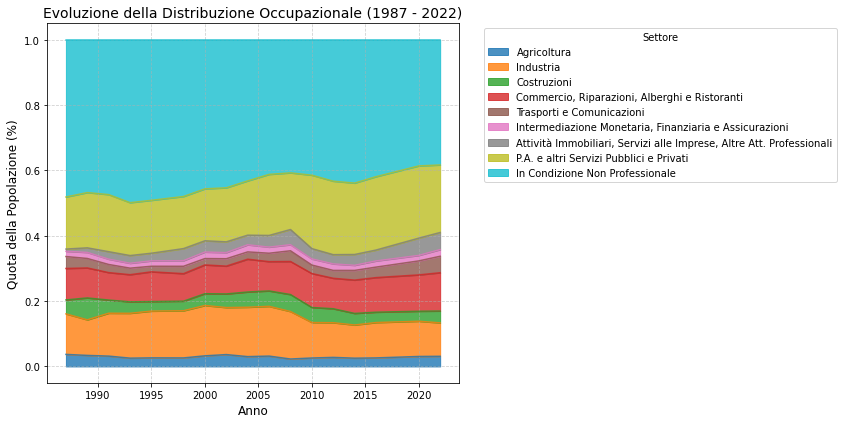

In [41]:
# Compute the weighted sum of population per sector per year
sector_weights = occ_df.groupby(['ANNO', 'SETTP9'])['PESOPOP'].sum().unstack(fill_value=0)

# Normalize to get the share of each sector (divide by total weighted population per year)
sector_shares = sector_weights.div(sector_weights.sum(axis=1), axis=0)

# Rename columns using mapped labels
sector_shares = sector_shares.rename(columns=settp9_labels)

# Plot as stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
sector_shares.plot(kind='area', stacked=True, colormap='tab10', alpha=0.8, ax=ax)

# Customize the plot
ax.set_title("Evoluzione della Distribuzione Occupazionale (1987 - 2022)", fontsize=14)
ax.set_xlabel("Anno", fontsize=12)
ax.set_ylabel("Quota della Popolazione (%)", fontsize=12)
ax.legend(title="Settore", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


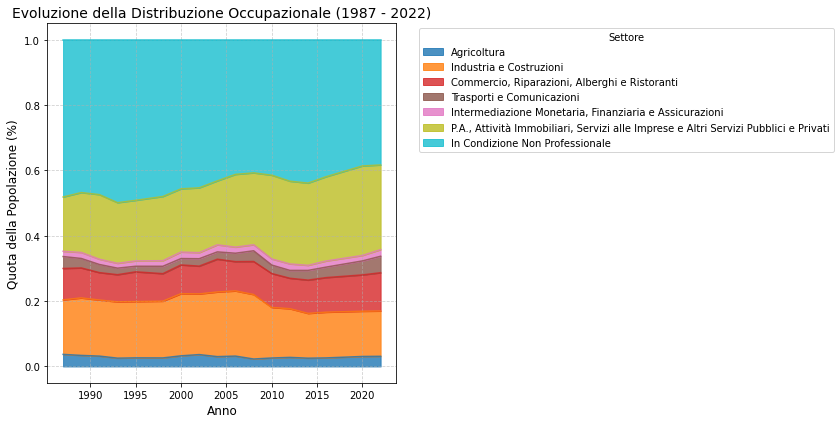

In [42]:
# Compute the weighted sum of population per sector per year
sector_weights = occ_df.groupby(['ANNO', 'SETTP7'])['PESOPOP'].sum().unstack(fill_value=0)

# Normalize to get the share of each sector (divide by total weighted population per year)
sector_shares = sector_weights.div(sector_weights.sum(axis=1), axis=0)

# Rename columns using mapped labels
sector_shares = sector_shares.rename(columns=settp7_labels)

# Plot as stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
sector_shares.plot(kind='area', stacked=True, colormap='tab10', alpha=0.8, ax=ax)

# Customize the plot
ax.set_title("Evoluzione della Distribuzione Occupazionale (1987 - 2022)", fontsize=14)
ax.set_xlabel("Anno", fontsize=12)
ax.set_ylabel("Quota della Popolazione (%)", fontsize=12)
ax.legend(title="Settore", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [43]:
sector_shares

SETTP7,Agricoltura,Industria e Costruzioni,"Commercio, Riparazioni, Alberghi e Ristoranti",Trasporti e Comunicazioni,"Intermediazione Monetaria, Finanziaria e Assicurazioni","P.A., Attività Immobiliari, Servizi alle Imprese e Altri Servizi Pubblici e Privati",In Condizione Non Professionale
ANNO,,,,,,,
1987,0.036980,0.166749,0.096211,0.036527,0.016047,0.166139,0.481347
1989,0.033891,0.175877,0.091806,0.029014,0.018369,0.183267,0.467777
1991,0.031745,0.171526,0.084008,0.024884,0.016097,0.197726,0.474014
1993,0.025498,0.172310,0.083107,0.020001,0.014837,0.185593,0.498654
1995,0.026363,0.172304,0.091017,0.017081,0.016370,0.185384,0.491480
1998,0.026195,0.173663,0.084225,0.022595,0.017083,0.196484,0.479756
2000,0.032593,0.190171,0.088040,0.019508,0.019826,0.193516,0.456346
2002,0.036391,0.185610,0.085108,0.022678,0.018609,0.198382,0.453222
2004,0.030173,0.197770,0.100397,0.022360,0.021592,0.195705,0.432004


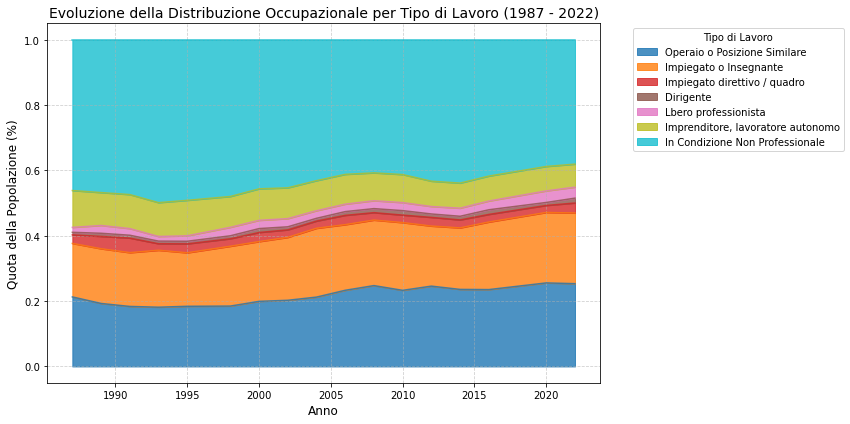

In [44]:
# Compute weighted sum of population per employment type per year
employment_weights = occ_df.groupby(['ANNO', 'QUALP7N'])['PESOPOP'].sum().unstack(fill_value=0)

# Normalize to compute the share per year
employment_shares = employment_weights.div(employment_weights.sum(axis=1), axis=0)

# Rename columns using mapped labels
employment_shares = employment_shares.rename(columns=qualp7_labels)

# Plot as stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
employment_shares.plot(kind='area', stacked=True, colormap='tab10', alpha=0.8, ax=ax)

# Customize the plot
ax.set_title("Evoluzione della Distribuzione Occupazionale per Tipo di Lavoro (1987 - 2022)", fontsize=14)
ax.set_xlabel("Anno", fontsize=12)
ax.set_ylabel("Quota della Popolazione (%)", fontsize=12)
ax.legend(title="Tipo di Lavoro", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [45]:
employment_shares
# qualp7_labels = {
#    1: 'Worker or Similar Position',
#    2: 'Employee or Teacher',
#    3: 'Executive / Manager',
#    4: 'Manager',
#    5: 'Freelancer',
#    6: 'Entrepreneur, Self-Employed Worker',
#    7: 'In Non-Professional Condition'
#}

QUALP7N,Operaio o Posizione Similare,Impiegato o Insegnante,Impiegato direttivo / quadro,Dirigente,Lbero professionista,"Imprenditore, lavoratore autonomo",In Condizione Non Professionale
ANNO,,,,,,,
1987,0.212931,0.163659,0.026316,0.007702,0.015087,0.112780,0.461526
1989,0.192885,0.167380,0.037838,0.009601,0.023855,0.100664,0.467777
1991,0.183773,0.164577,0.044645,0.008685,0.020338,0.104087,0.473895
1993,0.181431,0.174197,0.020066,0.008013,0.014153,0.103583,0.498557
1995,0.184174,0.163733,0.027404,0.007954,0.016680,0.108575,0.491480
1998,0.184895,0.182993,0.023045,0.009026,0.025868,0.094417,0.479756
2000,0.199287,0.182872,0.027954,0.011930,0.025217,0.096394,0.456346
2002,0.202616,0.192380,0.023126,0.009343,0.025043,0.094270,0.453222
2004,0.212316,0.210545,0.022148,0.008484,0.023198,0.091993,0.431316


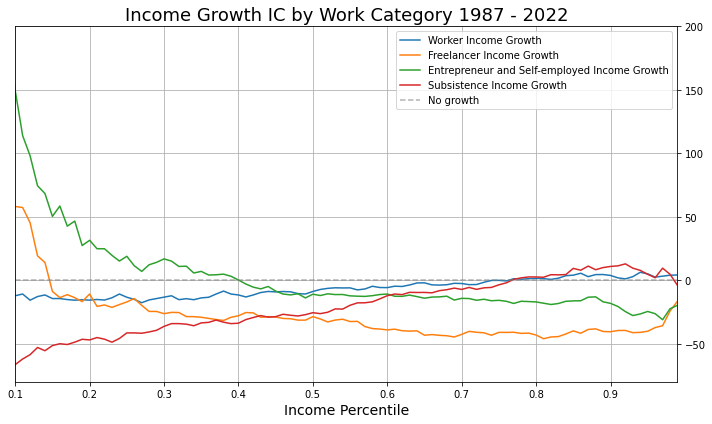

In [81]:
# Define work categories mapping

qualp7_labels = {
    1: 'Worker',
    2: 'Worker',
    3: 'Worker',
    4: 'Worker',
    5: 'Freelancer',
    6: 'Entrepreneur and Self-employed',
    7: 'Subsistence'
}

# Assign category labels to a new column
ind_df['Work_Category'] = ind_df['QUALP7N'].map(qualp7_labels)

work_category_thresholds = {}

for category in qualp7_labels.values():
    thresholds_dict = {}
    ind_df_category = ind_df.query(f'Work_Category == "{category}" and 15 < ETA < 65')
    
    for year, group in ind_df_category.groupby('Anno'):
        income = group['Y1'].values
        weights = group['PESOPOP'].values
        
        thresholds, _ = weighted_quantile(income, np.linspace(0.01, 0.99, 99), weights)
        thresholds_dict[year] = thresholds
    
    thresholds_df = pd.DataFrame(thresholds_dict, index=np.linspace(0.01, 0.99, 99))
    thresholds_df.index.name = "Percentile"
    
    defl_start = defl.query(f'Anno == 1987')['DEFL'].values[0]
    defl_end = defl.query(f'Anno == 2022')['DEFL'].values[0]
    
    thresholds_df = thresholds_df[[1987, 2022]]
    thresholds_df[2022] /= defl_end
    thresholds_df[1987] /= defl_start
    
    thresholds_df['Growth (%)'] = (thresholds_df[2022] - thresholds_df[1987]) / thresholds_df[1987] * 100
    work_category_thresholds[category] = thresholds_df

fig, ax = plt.subplots(figsize=(10, 6))

for category, df in work_category_thresholds.items():
    ax.plot(df.index, df['Growth (%)'], label=f"{category} Income Growth")

ax.axhline(y=0, color='grey', linestyle='--', alpha=0.6, label="No growth")
ax.set_title("Income Growth IC by Work Category 1987 - 2022", fontsize=18)
ax.set_xlabel("Income Percentile", fontsize=14)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylim(-80, 200)
ax.set_xlim(0.1, 0.99)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


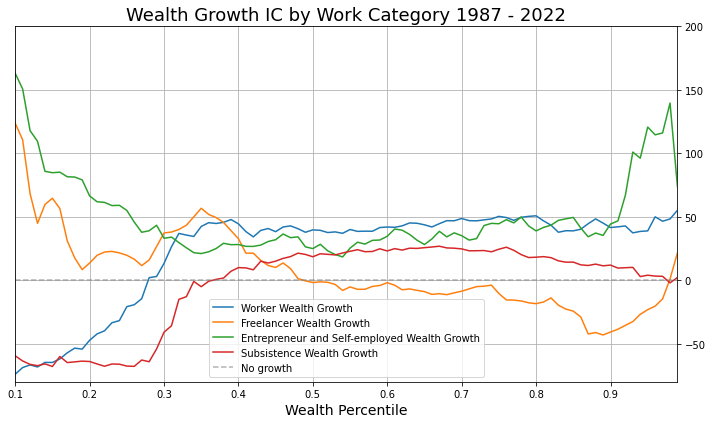

In [82]:
# Define work categories mapping
qualp7_labels = {
    1: 'Worker',
    2: 'Worker',
    3: 'Worker',
    4: 'Worker',
    5: 'Freelancer',
    6: 'Entrepreneur and Self-employed',
    7: 'Subsistence'
}

# Assign category labels to a new column
fw_df['Work_Category'] = fw_df['QUALP7N'].map(qualp7_labels)

work_category_thresholds = {}

for category in qualp7_labels.values():
    thresholds_dict = {}
    ind_df_category = fw_df.query(f'Work_Category == "{category}" and 15 < ETA < 65')
    
    for year, group in ind_df_category.groupby('Anno'):
        wealth = group['A'].values
        weights = group['PESOPOP'].values
        
        thresholds, _ = weighted_quantile(wealth, np.linspace(0.01, 0.99, 99), weights)
        thresholds_dict[year] = thresholds
    
    thresholds_df = pd.DataFrame(thresholds_dict, index=np.linspace(0.01, 0.99, 99))
    thresholds_df.index.name = "Percentile"
    
    defl_start = defl.query(f'Anno == 1987')['DEFL'].values[0]
    defl_end = defl.query(f'Anno == 2022')['DEFL'].values[0]
    
    thresholds_df = thresholds_df[[1987, 2022]]
    thresholds_df[2022] /= defl_end
    thresholds_df[1987] /= defl_start
    
    thresholds_df['Growth (%)'] = (thresholds_df[2022] - thresholds_df[1987]) / thresholds_df[1987] * 100
    work_category_thresholds[category] = thresholds_df

fig, ax = plt.subplots(figsize=(10, 6))

for category, df in work_category_thresholds.items():
    ax.plot(df.index, df['Growth (%)'], label=f"{category} Wealth Growth")

ax.axhline(y=0, color='grey', linestyle='--', alpha=0.6, label="No growth")
ax.set_title("Wealth Growth IC by Work Category 1987 - 2022", fontsize=18)
ax.set_xlabel("Wealth Percentile", fontsize=14)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylim(-80, 200)
ax.set_xlim(0.1, 0.99)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


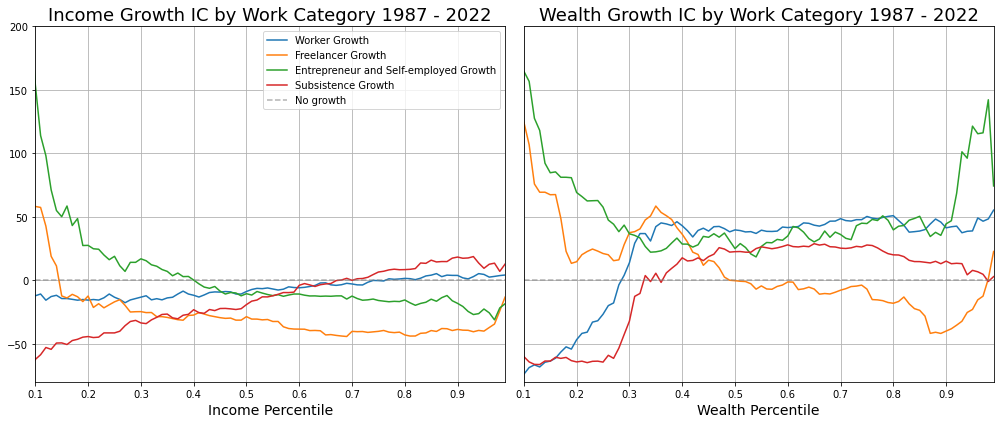

In [150]:
qualp7_labels = {
    1: 'Worker',
    2: 'Worker',
    3: 'Worker',
    4: 'Worker',
    5: 'Freelancer',
    6: 'Entrepreneur and Self-employed',
    7: 'Subsistence'
}

# Assign category labels to a new column
fw_df['Work_Category'] = fw_df['QUALP7N'].map(qualp7_labels)
ind_df['Work_Category'] = ind_df['QUALP7N'].map(qualp7_labels)

wealth_category_thresholds = {}
income_category_thresholds = {}

# Wealth calculation using fw_df
for category in qualp7_labels.values():
    thresholds_dict_wealth = {}
    fw_df_category = fw_df.query(f'Work_Category == "{category}" and ETA <= 65')
    
    for year, group in fw_df_category.groupby('Anno'):
        wealth = group['A'].values
        weights = group['PESOPOP'].values
        
        thresholds_wealth, _ = weighted_quantile(wealth, np.linspace(0.01, 0.99, 99), weights)
        thresholds_dict_wealth[year] = thresholds_wealth
    
    thresholds_df_wealth = pd.DataFrame(thresholds_dict_wealth, index=np.linspace(0.01, 0.99, 99))
    thresholds_df_wealth.index.name = "Percentile"
    
    defl_start = defl.query(f'Anno == 1987')['DEFL'].values[0]
    defl_end = defl.query(f'Anno == 2022')['DEFL'].values[0]
    
    thresholds_df_wealth = thresholds_df_wealth[[1987, 2022]]
    thresholds_df_wealth[2022] /= defl_end
    thresholds_df_wealth[1987] /= defl_start
    
    thresholds_df_wealth['Growth (%)'] = (thresholds_df_wealth[2022] - thresholds_df_wealth[1987]) / thresholds_df_wealth[1987] * 100
    
    wealth_category_thresholds[category] = thresholds_df_wealth

# Income calculation using ind_df
for category in qualp7_labels.values():
    thresholds_dict_income = {}
    ind_df_category = ind_df.query(f'Work_Category == "{category}" and ETA <= 65')
    
    for year, group in ind_df_category.groupby('Anno'):
        income = group['Y1'].values
        weights = group['PESOPOP'].values
        
        thresholds_income, _ = weighted_quantile(income, np.linspace(0.01, 0.99, 99), weights)
        thresholds_dict_income[year] = thresholds_income
    
    thresholds_df_income = pd.DataFrame(thresholds_dict_income, index=np.linspace(0.01, 0.99, 99))
    thresholds_df_income.index.name = "Percentile"
    
    thresholds_df_income = thresholds_df_income[[1987, 2022]]
    thresholds_df_income[2022] /= defl_end
    thresholds_df_income[1987] /= defl_start
    
    thresholds_df_income['Growth (%)'] = (thresholds_df_income[2022] - thresholds_df_income[1987]) / thresholds_df_income[1987] * 100
    
    income_category_thresholds[category] = thresholds_df_income

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wealth Growth (Left Plot)
for category, df in wealth_category_thresholds.items():
    axes[1].plot(df.index, df['Growth (%)'], label=f"{category} Wealth Growth")
axes[1].axhline(y=0, color='grey', linestyle='--', alpha=0.6, label="No growth")
axes[1].set_title("Wealth Growth IC by Work Category 1987 - 2022", fontsize=18)
axes[1].set_xlabel("Wealth Percentile", fontsize=14)
axes[1].tick_params(left=False, labelleft=False)
axes[1].set_ylim(-80, 200)
axes[1].set_xlim(0.1, 0.99)
axes[1].grid(True)

# Income Growth (Right Plot)
for category, df in income_category_thresholds.items():
    axes[0].plot(df.index, df['Growth (%)'], label=f"{category} Growth")
axes[0].axhline(y=0, color='grey', linestyle='--', alpha=0.6, label="No growth")
axes[0].set_title("Income Growth IC by Work Category 1987 - 2022", fontsize=18)
axes[0].set_xlabel("Income Percentile", fontsize=14)
axes[0].set_ylim(-80, 200)
axes[0].set_xlim(0.1, 0.99)
axes[0].legend()
axes[0].grid(True)

plt.tight_layout()
plt.show()


In [129]:
wealth_category_thresholds.keys()

dict_keys(['Worker', 'Freelancer', 'Entrepreneur and Self-employed', 'Subsistence'])

In [140]:
wealth_category_thresholds['Subsistence'].head(21)

,1987,2022,Growth (%)
Percentile,,,
0.01,0.000000,0.000000,NaN
0.02,0.000000,0.000000,NaN
0.03,0.000000,0.000000,NaN
0.04,0.000000,177.797260,inf
0.05,0.000000,242.591296,inf
0.06,132.327755,355.594519,168.722552
0.07,623.203027,444.493149,-28.676029
0.08,901.295581,444.493149,-50.682866
0.09,1246.406054,533.391779,-57.205617


In [121]:
low_start = wealth_category_thresholds['Worker'][1987][0.11]
low_end = wealth_category_thresholds['Worker'][2022][0.11]

high_start = wealth_category_thresholds['Worker'][1987][0.99]
high_end = wealth_category_thresholds['Worker'][2022][0.99]

((high_end-low_end) - (high_start - low_start)) / low_start

39.69397212396317

In [126]:
(high_end-low_end) / low_end

2773.4924736911216

In [125]:
low_start = wealth_category_thresholds['Worker'][1987][0.11]
low_end = wealth_category_thresholds['Worker'][2022][0.11]

high_start = wealth_category_thresholds['Entrepreneur and Self-employed'][1987][0.99]
high_end = wealth_category_thresholds['Entrepreneur and Self-employed'][2022][0.99]

((high_end-low_end) - (high_start - low_start)) / low_start

369.9551641965144

In [ ]:
growth_df_Y1

,Percentile,thr_start,bracketavg_start,thr_end,bracketavg_end,thr_growth,bracketavg_growth
0,0.00000,0.000000,324.729119,0.000000e+00,3.793737e+02,NaN,16.827753
1,0.01000,644.679970,961.006520,7.348482e+02,1.073284e+03,13.986515,11.683356
2,0.02000,1276.276081,1589.961092,1.406902e+03,1.733393e+03,10.234915,9.021116
3,0.03000,1903.026222,2215.057495,2.057131e+03,2.376314e+03,8.097872,7.280030
4,0.04000,2526.649980,2837.474341,2.693580e+03,3.007511e+03,6.606789,5.992533
...,...,...,...,...,...,...,...
122,0.99995,259262.228807,263816.875314,7.267122e+05,7.660549e+05,180.300069,190.373739
123,0.99996,268755.158027,274687.003650,8.100429e+05,8.667189e+05,201.405539,215.529642
124,0.99997,281270.556466,289695.893180,9.321656e+05,1.024261e+06,231.412438,253.564256
125,0.99998,299453.921206,313730.840248,1.137062e+06,1.328674e+06,279.711740,323.507612


In [ ]:
low_start = wealth_category_thresholds['Worker'][1987][0.11]
low_end = wealth_category_thresholds['Worker'][2022][0.11]

high_start = wealth_category_thresholds['Worker'][1987][0.99]
high_end = wealth_category_thresholds['Worker'][2022][0.99]

((high_end-low_end) - (high_start - low_start)) / low_start

39.69397212396317

In [ ]:
wealth_category_thresholds['Worker'].index = range(1, len(wealth_category_thresholds['Worker']) + 1)

In [ ]:
wealth_category_thresholds['Worker']

,1987,2022,Growth (%)
1,249.281211,0.000000,-100.000000
2,1219.135680,0.000000,-100.000000
3,1695.408475,177.797260,-89.513013
4,2726.382022,418.945431,-84.633649
5,3875.519952,711.189039,-81.649197
...,...,...,...
95,420600.009210,584117.426342,38.877179
96,436119.325975,650141.709176,49.074272
97,480818.679550,704467.968120,46.514268
98,542697.111446,804962.712042,48.326331


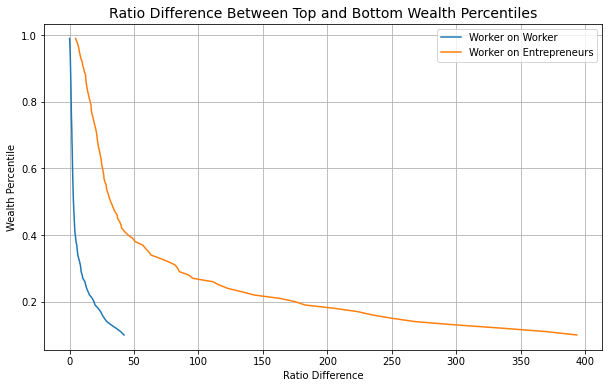

In [179]:
# Define the range of percentiles (['Worker', 'Freelancer', 'Entrepreneur and Self-employed', 'Subsistence'])
percentiles = range(10, 100)
dataframe = wealth_category_thresholds['Worker']
dataframe.index = range(1, len(dataframe) + 1)

# Initialize lists to store the computed values
ratio_diffs = []
x_values = []  # Stores corresponding percentiles from the dataframe

# Compute ratio_diff for each percentile
for bottom in percentiles:
    top = 99  # Fixed top percentile position (99.9th percentile)
    
    bottom_start = dataframe[1987][bottom]
    bottom_end = dataframe[2022][bottom]
    top_start = dataframe[1987][top]
    top_end = dataframe[2022][top]
    
    diff_start = top_start - bottom_start  # Difference rich to poor (initial)
    diff_end = top_end - bottom_end        # Difference rich to poor (final)
    diff = diff_end - diff_start           # Change in difference
    ratio_diff = diff / bottom_start       # Ratio of difference change to initial bottom wealth
    
    ratio_diffs.append(ratio_diff)
    x_values.append(growth_df_Y1.iloc[bottom]['Percentile'])  # Store actual percentile values

# Convert to DataFrame for plotting
df_ratio_ww = pd.DataFrame({'Percentile': x_values, 'Ratio_Diff': ratio_diffs})


# POOR WORKER ON RICH ENTREPRENEUR
percentiles = range(10, 100)
df_w = wealth_category_thresholds['Worker']
df_w.index = range(1, len(df_w) + 1)
df_en = wealth_category_thresholds['Entrepreneur and Self-employed']
df_en.index = range(1, len(df_en) + 1)

ratio_diffs = []
x_values = []  # Stores corresponding percentiles from the dataframe

# Compute ratio_diff for each percentile
for bottom in percentiles:
    top = 99  # Fixed top percentile position (99.9th percentile)
    
    bottom_start = df_w[1987][bottom]
    bottom_end = df_w[2022][bottom]
    top_start = df_en[1987][top]
    top_end = df_en[2022][top]
    
    diff_start = top_start - bottom_start  # Difference rich to poor (initial)
    diff_end = top_end - bottom_end        # Difference rich to poor (final)
    diff = diff_end - diff_start           # Change in difference
    ratio_diff = diff / bottom_start       # Ratio of difference change to initial bottom wealth
    
    ratio_diffs.append(ratio_diff)
    x_values.append(growth_df_Y1.iloc[bottom]['Percentile'])  # Store actual percentile values

# Convert to DataFrame for plotting
df_ratio_wen = pd.DataFrame({'Percentile': x_values, 'Ratio_Diff': ratio_diffs})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_ratio_ww['Ratio_Diff'], df_ratio_ww['Percentile'], linestyle='-', label='Worker on Worker')
plt.plot(df_ratio_wen['Ratio_Diff'], df_ratio_wen['Percentile'], linestyle='-', label='Worker on Entrepreneurs')

plt.title("Ratio Difference Between Top and Bottom Wealth Percentiles", fontsize=14)
plt.ylabel("Wealth Percentile")
plt.xlabel("Ratio Difference")
plt.legend()
plt.grid(True)
plt.show()


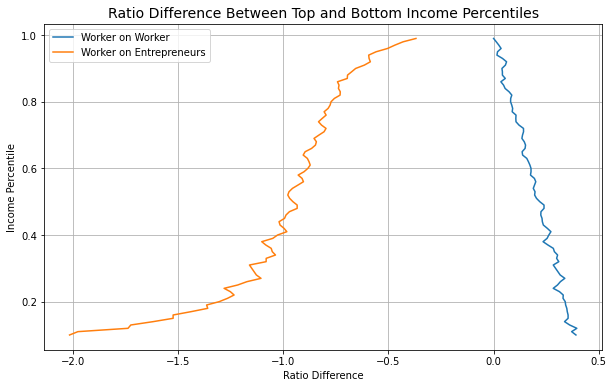

In [178]:
# Define the range of percentiles (['Worker', 'Freelancer', 'Entrepreneur and Self-employed', 'Subsistence'])
percentiles = range(10, 100)
dataframe = income_category_thresholds['Worker']
dataframe.index = range(1, len(dataframe) + 1)

# Initialize lists to store the computed values
ratio_diffs = []
x_values = []  # Stores corresponding percentiles from the dataframe

# Compute ratio_diff for each percentile
for bottom in percentiles:
    top = 99  # Fixed top percentile position (99.9th percentile)
    
    bottom_start = dataframe[1987][bottom]
    bottom_end = dataframe[2022][bottom]
    top_start = dataframe[1987][top]
    top_end = dataframe[2022][top]
    
    diff_start = top_start - bottom_start  # Difference rich to poor (initial)
    diff_end = top_end - bottom_end        # Difference rich to poor (final)
    diff = diff_end - diff_start           # Change in difference
    ratio_diff = diff / bottom_start       # Ratio of difference change to initial bottom wealth
    
    ratio_diffs.append(ratio_diff)
    x_values.append(growth_df_Y1.iloc[bottom]['Percentile'])  # Store actual percentile values

# Convert to DataFrame for plotting
df_ratio_ww = pd.DataFrame({'Percentile': x_values, 'Ratio_Diff': ratio_diffs})


# POOR WORKER ON RICH ENTREPRENEUR
percentiles = range(10, 100)
df_w = income_category_thresholds['Worker']
df_w.index = range(1, len(df_w) + 1)
df_en = income_category_thresholds['Entrepreneur and Self-employed']
df_en.index = range(1, len(df_en) + 1)

ratio_diffs = []
x_values = []  # Stores corresponding percentiles from the dataframe

# Compute ratio_diff for each percentile
for bottom in percentiles:
    top = 99  # Fixed top percentile position (99.9th percentile)
    
    bottom_start = df_w[1987][bottom]
    bottom_end = df_w[2022][bottom]
    top_start = df_en[1987][top]
    top_end = df_en[2022][top]
    
    diff_start = top_start - bottom_start  # Difference rich to poor (initial)
    diff_end = top_end - bottom_end        # Difference rich to poor (final)
    diff = diff_end - diff_start           # Change in difference
    ratio_diff = diff / bottom_start       # Ratio of difference change to initial bottom wealth
    
    ratio_diffs.append(ratio_diff)
    x_values.append(growth_df_Y1.iloc[bottom]['Percentile'])  # Store actual percentile values

# Convert to DataFrame for plotting
df_ratio_wen = pd.DataFrame({'Percentile': x_values, 'Ratio_Diff': ratio_diffs})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_ratio_ww['Ratio_Diff'], df_ratio_ww['Percentile'], linestyle='-', label='Worker on Worker')
plt.plot(df_ratio_wen['Ratio_Diff'], df_ratio_wen['Percentile'], linestyle='-', label='Worker on Entrepreneurs')

plt.title("Ratio Difference Between Top and Bottom Income Percentiles", fontsize=14)
plt.ylabel("Income Percentile")
plt.xlabel("Ratio Difference")
plt.legend()
plt.grid(True)
plt.show()
